In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
import joblib
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# LÀM SẠCH DỮ LIỆU

In [ ]:
# Đọc dữ liệu từ file "diabetes.csv"
df = pd.read_csv("/content/diabetes.csv")


In [ ]:
# Kiểm tra kích thước tập dữ liệu
df.shape

(100000, 9)

In [ ]:
# Tên các thuộc tính có trong tập dữ liệu
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [ ]:
# In thử 10 dòng đầu tiên trong tập dữ liệu
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [ ]:
# Miêu tả tập dữ liệu
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
# Kiểm tra dữ liệu thiếu
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Không có dữ liệu thiếu trong tập dữ liệu

In [ ]:
# Kiểm tra giá trị của các thuộc tính
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        print(f"Column: {col}")
        min_val = df[col].min()
        max_val = df[col].max()
        print(f"Minimum value: {min_val}")
        print(f"Maximum value: {max_val}")
    else:
        print(f"Column: {col}")
        unique_values = df[col].unique()
        print("Values: ",unique_values)


Column: gender
Values:  ['Female' 'Male' 'Other']
Column: age
Minimum value: 0.08
Maximum value: 80.0
Column: hypertension
Minimum value: 0
Maximum value: 1
Column: heart_disease
Minimum value: 0
Maximum value: 1
Column: smoking_history
Values:  ['never' 'No Info' 'current' 'former' 'ever' 'not current']
Column: bmi
Minimum value: 10.01
Maximum value: 95.69
Column: HbA1c_level
Minimum value: 3.5
Maximum value: 9.0
Column: blood_glucose_level
Minimum value: 80
Maximum value: 300
Column: diabetes
Minimum value: 0
Maximum value: 1


Các thuộc tính khác có giá trị bình thường.

Đối với giới tính (gender) có giá trị "Other": không thuộc "nam" hay "nữ" => dữ liệu bất thường.

Đối với độ tuổi (age) thấp nhất là: 0.08 (4 tuần tuổi/ 1 tháng tuổi) là quá nhỏ đối với độ tuổi mắc bệnh tiểu đường hoặc có khả năng mắc bệnh tiểu đường

Đối với lịch sử hút thuốc, có các giá trị "No Info": không có thông tin về lịch sử hút thuốc của bệnh nhân.

=> Xử lý dữ liệu ngoại lai

In [ ]:
# Đếm số dòng có giá trị 'Other' trong cột 'gender'
num_other = (df['gender'] == 'Other').sum()
print(f"Số dòng có giá trị 'Other' trong cột 'gender': {num_other}")

Số dòng có giá trị 'Other' trong cột 'gender': 18


In [ ]:
# Xóa các dòng có giá trị "Other" trong cột "gender"
df = df[df['gender'] != 'Other'].reset_index(drop=True)

# Kích thước tập dữ liệu sau khi xóa
print("Kích thước tập dữ liệu sau khi đã xóa: ")
df.shape

Kích thước tập dữ liệu sau khi đã xóa: 


(99982, 9)

In [ ]:
# Lọc các giá trị thuộc "age" nhỏ hơn 5 tuổi
low_ages = df[df['age'] < 5]['age']

# In ra số lượng dòng
print(f"Có {len(low_ages)} dòng chứa giá trị 'age' nhỏ hơn 5.")

# In ra 15 dòng đầu tiên
print("15 dòng đầu tiên:")
for i, age in enumerate(low_ages.head(15)):
    print(f"{i+1}. {age}")

Có 5278 dòng chứa giá trị 'age' nhỏ hơn 5.
15 dòng đầu tiên:
1. 4.0
2. 3.0
3. 2.0
4. 3.0
5. 0.08
6. 3.0
7. 0.56
8. 2.0
9. 2.0
10. 0.88
11. 4.0
12. 4.0
13. 4.0
14. 4.0
15. 0.16


Số lượng độ tuổi < 5 trong tập dữ liệu là 5278 dòng Những độ tuổi này quá nhỏ => độ tin cậy của tập dữ liệu có thể bị ảnh hưởng và độ tuổi có thể có nguy cơ mắc bệnh tiểu đường là từ 5 tuổi.

In [ ]:
# Xóa các dòng có độ tuổi nhỏ hơn 5
df = df[df['age'] >= 5].reset_index(drop=True)

# Kích thước tập dữ liệu sau khi xóa
print("Kích thước tập dữ liệu sau khi đã xóa: ")
df.shape

Kích thước tập dữ liệu sau khi đã xóa: 


(94704, 9)

In [ ]:
# Kiểm tra số lượng các giá trị trong lịch sử hút thuốc
print(df['smoking_history'].value_counts())

smoking_history
never          34547
No Info        31154
former          9352
current         9271
not current     6378
ever            4002
Name: count, dtype: int64


Nhận thấy trong tập dữ liệu chứa khá nhiều dữ liệu "No Info".

Cách xử lý:

1. Xóa bỏ các dữ liệu không có thông tin.

2. Sử dụng kỹ thuật khác như điền giá trị trung bình, giá trị phổ biến, hoặc dự đoán giá trị dựa trên các thuộc tính khác.

=> Giá trị "No Info" không ảnh hưởng đến tập dữ liệu, vì khi dùng các giá trị để dự đoán, không dùng thuộc tính "smoking_history"

In [ ]:
# Xóa các dòng không có thông tin trong tập dữ liệu
#df = df.drop(df[df['smoking_history'] == 'No Info'].index)

# Kích thước tập dữ liệu sau khi xóa
#print("Kích thước tập dữ liệu sau khi đã xóa: ")
#df.shape

In [ ]:
#Kiểm tra số lượng các dòng bị trùng lặp
df.duplicated().sum()

3749

Số dòng bị trùng là 3749.

Đối với các tập dữ liệu lớn, việc có dữ liệu bị trùng lặp có thể gây ra các vấn đề sau:

1. Hiệu suất kém: Các bản ghi trùng lặp sẽ làm tăng kích thước tập dữ liệu, dẫn đến việc tải và xử lý dữ liệu chậm hơn. Điều này đặc biệt quan trọng khi làm việc với các tập dữ liệu lớn.

2. Phân tích dữ liệu và mô hình hóa bị sai lệch: Các bản ghi trùng lặp có thể làm cho dữ liệu không đại diện chính xác cho mẫu nghiên cứu, dẫn đến các kết quả phân tích và mô hình hóa bị sai lệch.

3. Kết luận không chính xác: Các bản ghi trùng lặp có thể khiến kết luận không chính xác về dữ liệu, ví dụ như ước lượng không chính xác về tần suất hoặc phân bố của các biến.

4. Tiêu tốn tài nguyên: Lưu trữ và xử lý các bản ghi trùng lặp sẽ tiêu tốn bộ nhớ và tài nguyên máy tính không cần thiết.

In [ ]:
# Xóa các dòng bị trùng lặp
df.drop_duplicates(inplace=True)

# In ra kích thước của DataFrame sau khi xóa
print("Kích thước của DataFrame sau khi xóa các dòng trùng lặp:")
print(df.shape)

Kích thước của DataFrame sau khi xóa các dòng trùng lặp:
(90955, 9)


In [ ]:
# Kiểm tra tính nhất quán của dữ liệu
# In ra định dạng của các cột
print(df.dtypes)

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


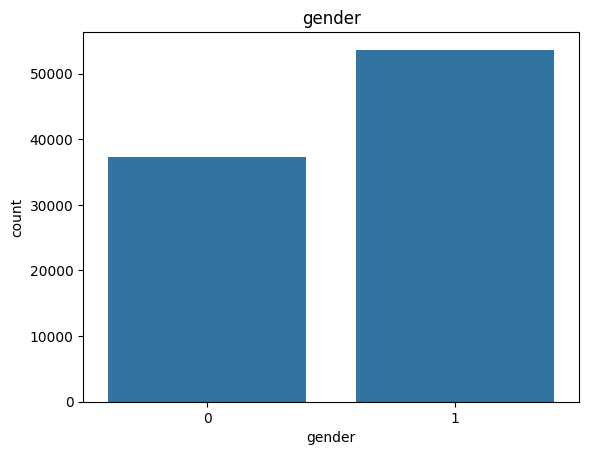

In [ ]:
# Mã hóa thuộc tính gender
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

sns.countplot(x='gender', data=df)
plt.title('gender')
plt.show()

In [ ]:
# Chuẩn hóa cột age thành kiểu int
df['age'] = df['age'].astype(int)

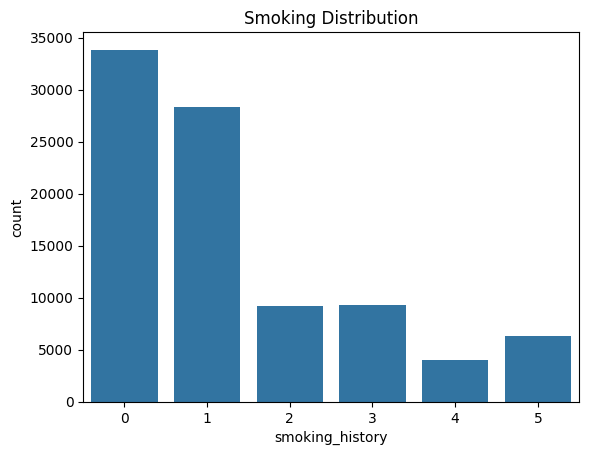

In [ ]:
# Mã hóa dữ liệu cột smoking_history
df['smoking_history'] = df['smoking_history'].replace(['never', 'No Info', 'current', 'former', 'ever', 'not current'], [0, 1, 2, 3, 4, 5])

sns.countplot(x='smoking_history', data=df)
plt.title('Smoking Distribution')
plt.show()

In [ ]:
#Kiểm tra lại kích thước tập dữ liệu sau khi tiền xử lý dữ liệu
df.shape

(90955, 9)

# CẮT DỮ LIỆU GÓC RA ĐỂ LÀM THỰC NGHIỆM

In [ ]:
# Lấy các mẫu có nhãn diabetes là 0 và 1
df_diabetes_0 = df[df['diabetes'] == 0]
df_diabetes_1 = df[df['diabetes'] == 1]

# Lấy ngẫu nhiên 700 mẫu từ df_diabetes_0 và 300 mẫu từ df_diabetes_1
sample_700 = df_diabetes_0.sample(n=700, random_state=42)
sample_300 = df_diabetes_1.sample(n=300, random_state=42)

# Kết hợp lại thành một DataFrame duy nhất
sampled_df = pd.concat([sample_700, sample_300])

# Loại bỏ các mẫu đã được chọn khỏi tập dữ liệu gốc
df = df.drop(sampled_df.index)

# Lưu kết quả vào file CSV
sampled_df.to_csv('sampled_data.csv', index=False)

In [ ]:
sampled_df.shape

(1000, 9)

In [ ]:
#Kiểm tra lại kích thước tập dữ liệu sau khi tiền xử lý dữ liệu
df.shape

(89955, 9)

In [ ]:
# Lưu lại file
df.to_csv('diabetes_new.csv', index=False)

# TRỰC QUAN HÓA DỮ LIỆU

In [ ]:
# Đọc dữ liệu vào DataFrame
df = pd.read_csv('diabetes_new.csv')

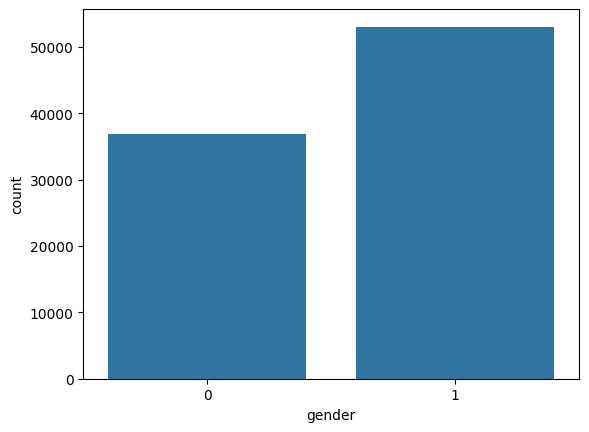

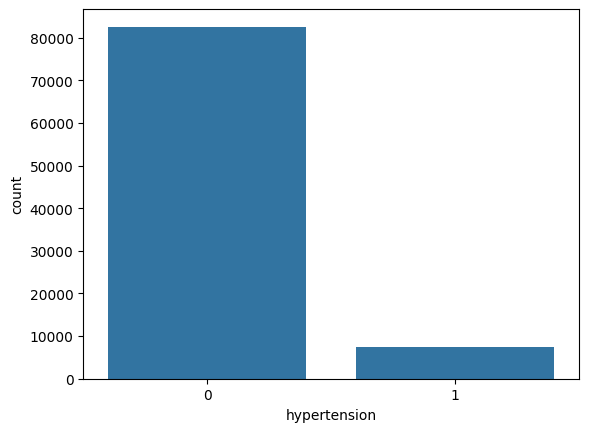

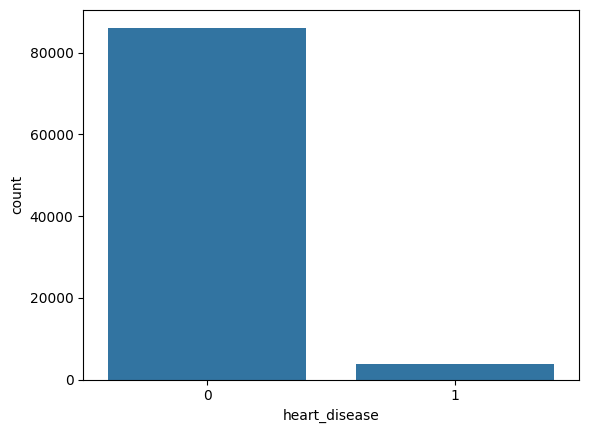

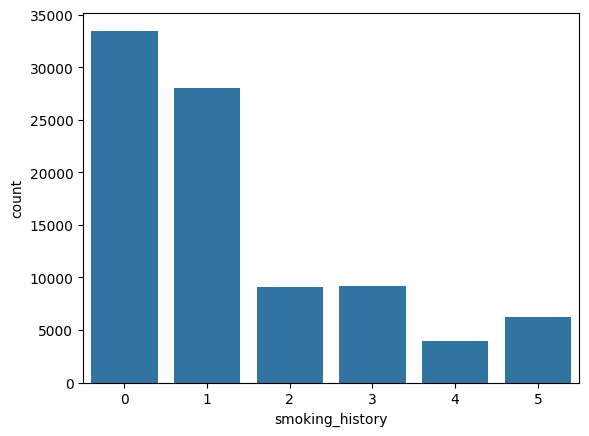

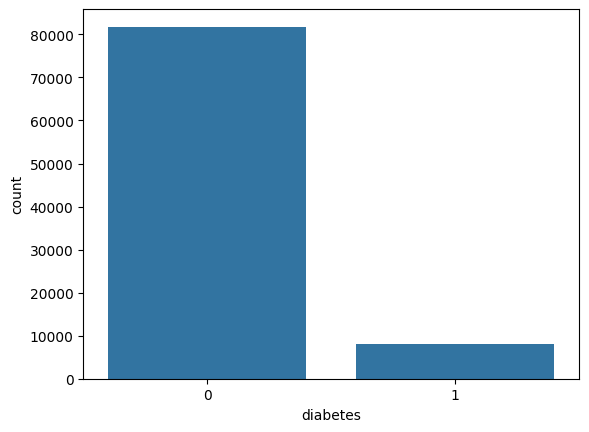

In [ ]:
# Trực quan dữ liệu phân loại
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']
for column in categorical_columns:
    sns.countplot(x=column, data=df)
    plt.show()

Tổng quan, một số thuộc tính có các giá trị khá chênh lệch nhau. Chẳng hạn như: hypertension (tăng huyết áp), heart_disease (bệnh tim mạch) có số lượng 0 rất nhiều hơn so với 1.

In [ ]:
# Số lượng các giá trị trong diabetes
df['diabetes'].value_counts()

diabetes
0    81780
1     8175
Name: count, dtype: int64

Những người không mắc bệnh tiểu đường: 82480

Những người mắc bện tiểu đường: 8475

In [ ]:
# Tính toán ma trận tương quan giữa các cặp biến trong tập dữ liệu
correlation = df.corr()
correlation['diabetes'].sort_values(ascending=False)

diabetes               1.000000
blood_glucose_level    0.427279
HbA1c_level            0.411442
age                    0.255497
bmi                    0.204181
hypertension           0.191628
heart_disease          0.165688
smoking_history        0.051102
gender                -0.042212
Name: diabetes, dtype: float64

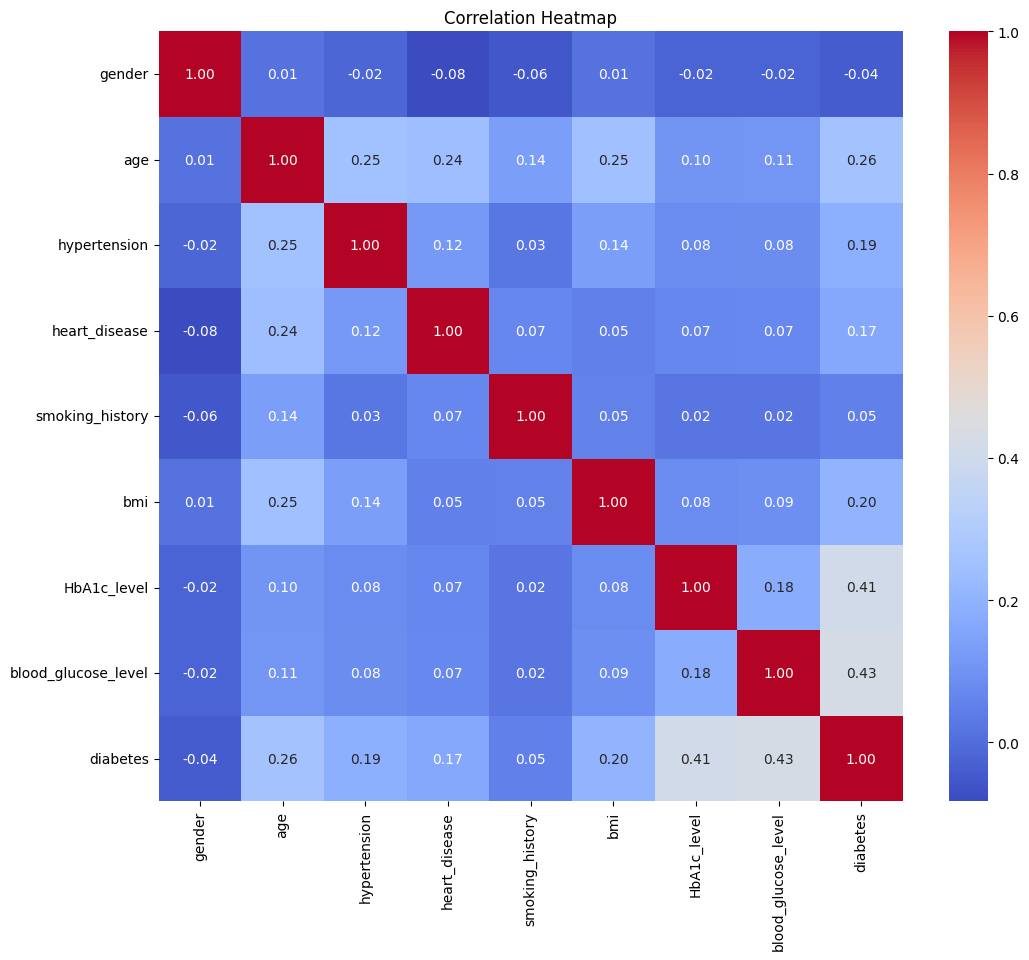

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Các thuộc tính có mối tương quan cao với diabetes (mắc bệnh tiểu đường) là:

- blood_glucose_level 43%

- HbA1c_level 41%

- age 25%

- bmi 20%

- hypertension 19%

- heart_diease 16%

Các thuộc tính còn lại có tương quan âm/ dương nhưng không đáng kể

Đối với thuộc tính gender và smoking_history có giá trị rất thấp, không thể hiện được sự tương quan đối với dibetes => Không dùng đến trong quá trình chẩn đoán bệnh.

In [ ]:
# Xóa 2 cột gender và smoking_history
df.drop("gender",axis=1)
df.drop("smoking_history",axis=1)

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80,0,1,25.19,6.6,140,0
1,1,54,0,0,27.32,6.6,80,0
2,0,28,0,0,27.32,5.7,158,0
3,1,36,0,0,23.45,5.0,155,0
4,0,76,1,1,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...
89950,1,40,0,0,40.69,3.5,155,0
89951,1,36,0,0,24.60,4.8,145,0
89952,0,66,0,0,27.83,5.7,155,0
89953,1,24,0,0,35.42,4.0,100,0


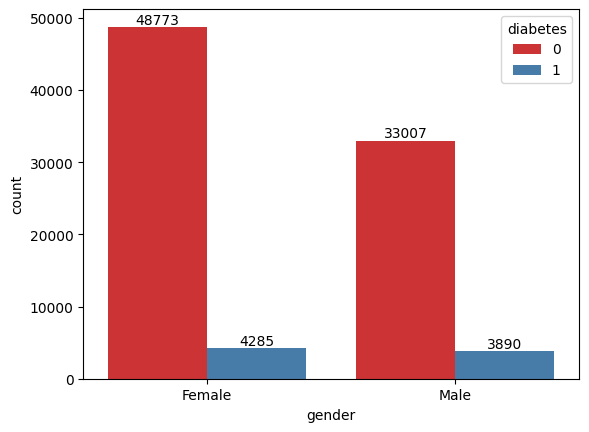

In [ ]:
# Gender vs Diabetes
ax = sns.countplot(x='gender', hue='diabetes', data=df, palette= "Set1")
for label in ax.containers:
    ax.bar_label(label)
plt.show()

Sự phân bố của bệnh nhân có bệnh (diabetes 1) trong 2 giới tính không có sự khác nhau => gender không ảnh hưởng đến khả năng mắc bệnh tiểu đường.

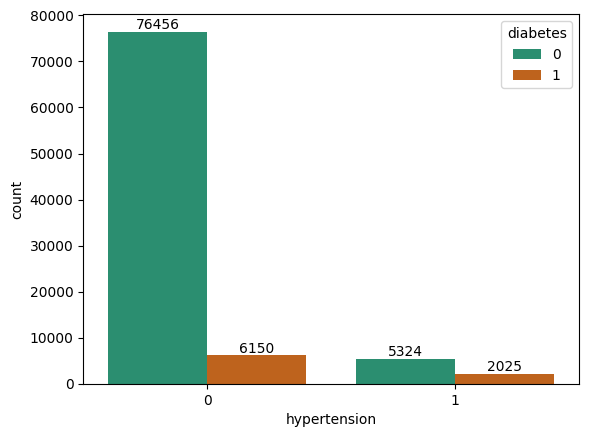

In [ ]:
# hypertension vs Diabetes
bx = sns.countplot(x='hypertension', hue='diabetes', data=df, palette='Dark2')
for label in bx.containers:
    bx.bar_label(label)
plt.show()

Sự phân bố của bệnh nhân bị tiểu đường (diabetes 1) có ở cả nhóm "không tăng huyết áp" và "có tăng huyết áp" trong hypertension.

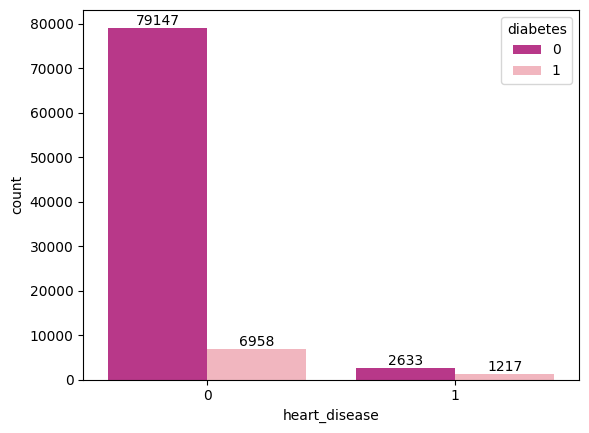

In [ ]:
# heart_disease vs Diabetes
cx = sns.countplot(x='heart_disease', hue='diabetes', data=df, palette='RdPu_r')
for label in cx.containers:
    cx.bar_label(label)
plt.show()

Sự phân bố của bệnh nhân bị tiểu đường (diabetes 1) có ở cả nhóm "không có bệnh tim" và "có bệnh tim" trong heart_disease.

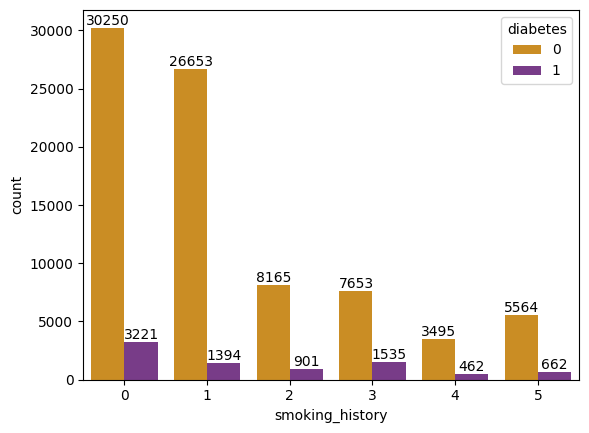

In [ ]:
# smoking_history vs Diabetes
dx = sns.countplot(x='smoking_history', hue='diabetes', data=df, palette='CMRmap_r')
for label in dx.containers:
    dx.bar_label(label)
plt.show()

Sự phân bố của bệnh nhân bị tiểu đường (diabetes 1) ở mỗi nhóm smoking_history không đồng đều.

Và số lượng người mắc bệnh ở mỗi nhóm không liên quan đến nguy cơ mắc bệnh tiểu đường. Cụ thể: ở nhóm 0 (không hút thuốc) thì số lượng bệnh nhân cao nhất. Và ở các nhóm còn lại cũng không có sự ảnh hưởng đáng kể đến diabetes.

<Axes: xlabel='diabetes', ylabel='bmi'>

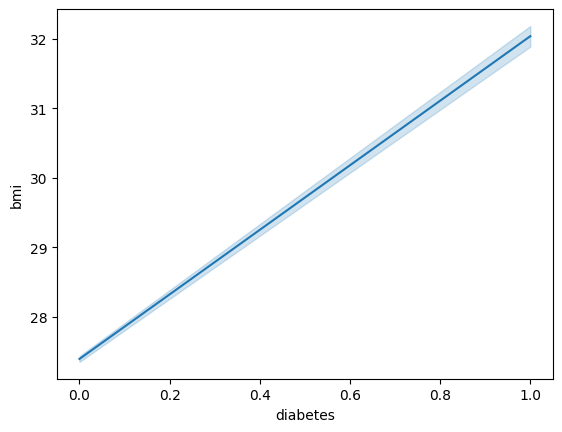

In [ ]:
# BMI and Diabetes
sns.lineplot(y='bmi', x='diabetes', data=df)

Mối quan hệ tuyến tính giữa những người có chỉ số BMI cao và bệnh tiểu đường. Một vài nhận xét có thể được rút ra từ đồ thị này:

- Mối quan hệ tuyến tính: Đường biểu diễn cho thấy một mối quan hệ tuyến tính gần như hoàn hảo giữa BMI và tỷ lệ mắc bệnh tiểu đường. Khi BMI tăng, tỷ lệ mắc bệnh tiểu đường cũng tăng theo một cách tương ứng.

- Xu hướng tăng dần: BMI tăng đều khi tỷ lệ mắc bệnh tiểu đường tăng, cho thấy những người có BMI cao hơn có nguy cơ mắc bệnh tiểu đường cao hơn.

- Khoảng tin cậy hẹp: Phần màu xanh nhạt xung quanh đường biểu diễn chính là khoảng tin cậy. Khoảng tin cậy này rất hẹp, điều này cho thấy mức độ chắc chắn cao của xu hướng tuyến tính giữa BMI và tỷ lệ mắc bệnh tiểu đường.

<Axes: xlabel='blood_glucose_level', ylabel='diabetes'>

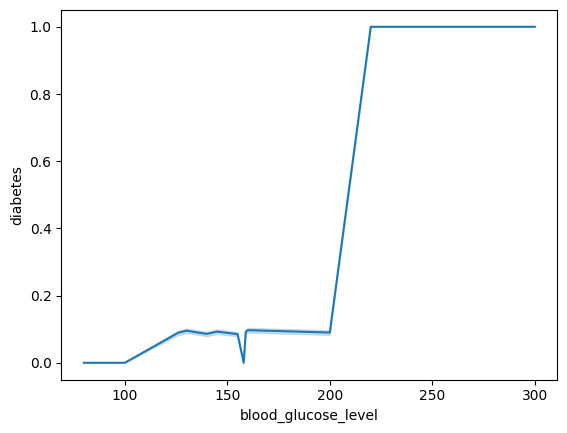

In [ ]:
# blood_glucose_level and Diabetes
sns.lineplot(x='blood_glucose_level', y='diabetes', data=df)

<Axes: xlabel='HbA1c_level', ylabel='diabetes'>

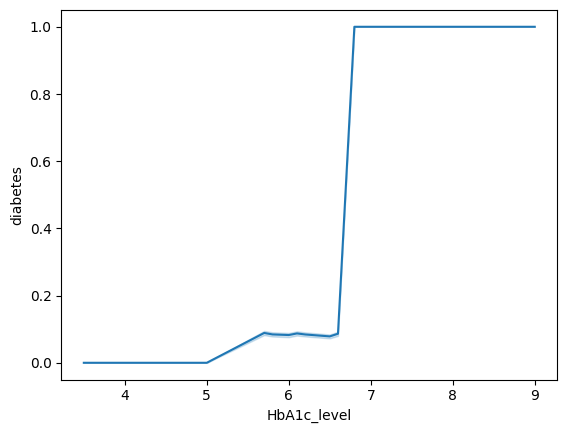

In [ ]:
# blood_glucose_level and Diabetes
sns.lineplot(x='HbA1c_level', y='diabetes', data=df)

Quan sát thấy rằng khi Hemoglobin A1c (mức đường trong máu trung bình) tăng lên, chúng tôi nhận thấy bệnh tiểu đường tăng đột ngột.
Đồ thị trên thể hiện mối quan hệ giữa mức đường huyết (blood_glucose_level) và tỷ lệ mắc bệnh tiểu đường (diabetes). Một vài nhận xét có thể được rút ra từ đồ thị này:

- Ngưỡng mức đường huyết cao: Mối quan hệ giữa mức đường huyết và tỷ lệ mắc bệnh tiểu đường không tuyến tính. Khi mức đường huyết dưới 200, tỷ lệ mắc bệnh tiểu đường tương đối thấp, thường dưới 0.2. Tuy nhiên, khi mức đường huyết vượt qua ngưỡng 200, tỷ lệ mắc bệnh tiểu đường tăng đột ngột lên 1.0, tức là gần như tất cả những người có mức đường huyết trên 200 đều mắc bệnh tiểu đường.

- Tăng đột biến: Đồ thị cho thấy sự tăng đột biến rõ rệt ở mức đường huyết khoảng 200. Điều này có thể cho thấy rằng mức đường huyết là một yếu tố chỉ báo quan trọng và nhạy cảm cho việc chẩn đoán bệnh tiểu đường.

- Ổn định ở mức cao: Sau khi vượt qua mức đường huyết 200, tỷ lệ mắc bệnh tiểu đường duy trì ở mức 1.0 mà không giảm, cho thấy sự ổn định của nguy cơ mắc bệnh tiểu đường ở mức đường huyết cao.

<Axes: xlabel='age', ylabel='diabetes'>

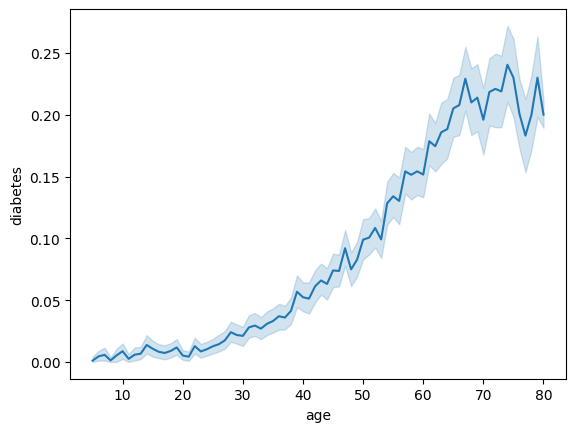

In [ ]:
# age vs diabetes
sns.lineplot(x='age', y='diabetes', data=df)

Đồ thị trên thể hiện mối quan hệ giữa tuổi tác (age) và tỷ lệ mắc bệnh tiểu đường (diabetes). Một vài nhận xét có thể được rút ra từ đồ thị này:

- Xu hướng tăng dần: Tỷ lệ mắc bệnh tiểu đường tăng dần theo độ tuổi. Điều này cho thấy rằng người cao tuổi có nguy cơ mắc bệnh tiểu đường cao hơn so với người trẻ.

- Giai đoạn nguy cơ cao: Sau độ tuổi 50, tỷ lệ mắc bệnh tiểu đường tăng nhanh hơn so với các giai đoạn trước đó. Đặc biệt, từ độ tuổi 60 trở lên, mức độ gia tăng tỷ lệ mắc bệnh rõ rệt hơn.

- Biến động: Đường biểu diễn không hoàn toàn mượt mà mà có những biến động nhỏ, đặc biệt ở những độ tuổi cao hơn. Điều này có thể phản ánh sự biến đổi trong dữ liệu thực tế hoặc các yếu tố ngẫu nhiên khác.

- Khoảng tin cậy: Phần màu xanh nhạt xung quanh đường biểu diễn chính là khoảng tin cậy. Khoảng tin cậy này cho thấy sự biến động của dữ liệu và mức độ chắc chắn của xu hướng được thể hiện. Ở độ tuổi cao, khoảng tin cậy rộng hơn, cho thấy sự biến động lớn hơn trong tỷ lệ mắc bệnh tiểu đường.

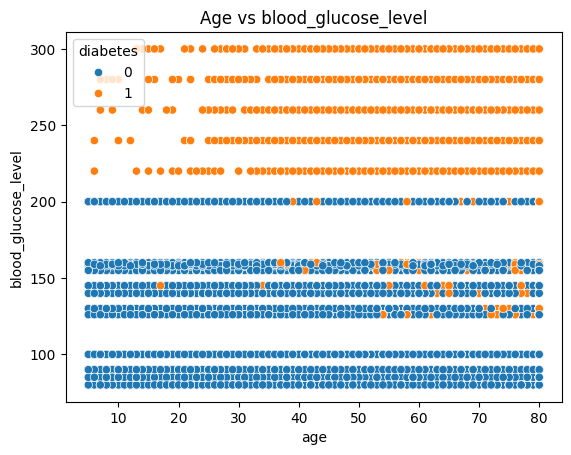

In [ ]:
sns.scatterplot(x='age', y='blood_glucose_level', hue='diabetes', data=df)
plt.title('Age vs blood_glucose_level')
plt.show()

Biểu đồ phân tán thể hiện mối quan hệ giữ age và blood_glucose_level với diabetes. Sự tập trung của các điểm dữ liệu sẽ thể hiện được mối tương quan giữa các thuộc tính đó.

1. Sự phân tán của bệnh nhân bị tiểu đường (diabetes 1) tập trung ở độ tuổi ngày càng cao.
2. Sự phân tán của bệnh nhân bị tiểu đường (diabetes 1) tập trung nhiều ở mức độ glucose ngày càng cao.
3. Ngoài ra, mật độ tập trung các điểm dữ liệu có có sự phân tán lớn và có sự đa dạng về "blood_glucose_level" và "age" trong tập dữ liệu. => Tuổi tác (age) và nồng độ glucose trong máu có sự tương quan với nguy cơ mắc bệnh tiểu đường (diabetes), nhưng không có nhiều sự tương quan với nhau.

=> Có thể cần xem xét các yếu tố khác để giải thích sự biến động của "diabetes".


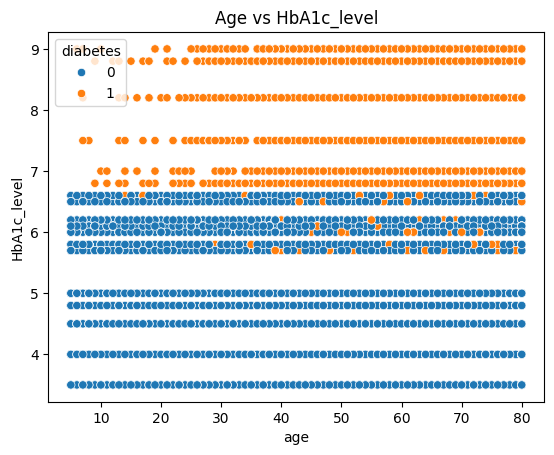

In [ ]:
sns.scatterplot(x='age', y='HbA1c_level', hue='diabetes', data=df)
plt.title('Age vs HbA1c_level')
plt.show()

Biểu đồ phân tán thể hiện mối quan hệ giữ age và HbA1c_level với diabetes.

1. Sự phân tán của bệnh nhân bị tiểu đường (diabetes 1) tập trung ở độ tuổi ngày càng cao.
2. Sự phân tán của bệnh nhân bị tiểu đường (diabetes 1) tập trung nhiều ở mức độ HbA1c ngày càng cao.
3. Mật độ tập trung các điểm dữ liệu thể hiện sự tương quan của độ tuổi và mức độ HbA1c với diabetes. Nhưng không có nhiều sự tương quan giữa 2 thuộc tính với nhau.



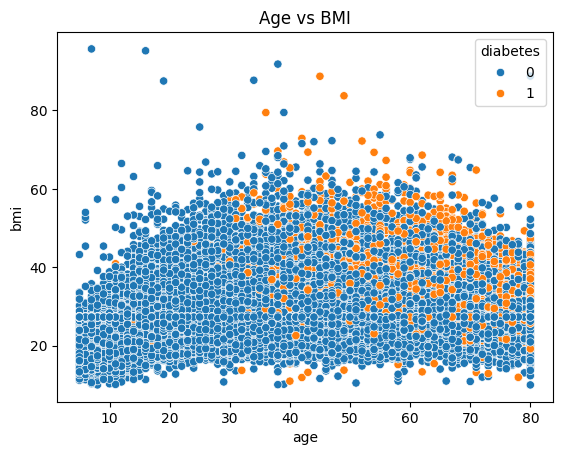

In [ ]:
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df)
plt.title('Age vs BMI')
plt.show()

Biểu đồ phân tán thể hiện mối quan hệ giữ age và bmi với diabetes.

Các điểm dữ liệu của bệnh nhân bị tiểu đường (diabetes 1) tập trung nhiều và ngày càng dày đặc ở phân khúc độ tuổi ngày càng cao và chỉ số bmi ngày càng cao. => Có sự tương quan giữa tuổi tác, bmi và nguy cơ mắc bệnh tiểu đường.

=> Các thuộc tính có sự tương quan với bệnh tiểu đường là: blood_glucose_level, HbA1c_level, age và bmi, hypertension, heart_disease

=> Chứng minh sự tương quan bằng một vài phương pháp tính toán

# XỬ LÝ DỮ LIỆU MẤT CÂN BẰNG

In [ ]:
# Đọc dữ liệu vào DataFrame
df = pd.read_csv('diabetes_new.csv')

In [ ]:
df.shape

(89955, 9)

In [ ]:
count_class_0, count_class_1 = df['diabetes'].value_counts()
print("Class 0:", count_class_0)
print("Class 1:", count_class_1)

Class 0: 81780
Class 1: 8175


In [ ]:
df_class_0 = df[df['diabetes'] == 0]
df_class_1 = df[df['diabetes'] == 1]

In [ ]:
df_class_0

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80,0,1,0,25.19,6.6,140,0
1,1,54,0,0,1,27.32,6.6,80,0
2,0,28,0,0,0,27.32,5.7,158,0
3,1,36,0,0,2,23.45,5.0,155,0
4,0,76,1,1,2,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
89950,1,40,0,0,0,40.69,3.5,155,0
89951,1,36,0,0,1,24.60,4.8,145,0
89952,0,66,0,0,3,27.83,5.7,155,0
89953,1,24,0,0,0,35.42,4.0,100,0


In [ ]:
df_class_1

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
6,1,44,0,0,0,19.31,6.5,200,1
25,0,67,0,1,5,27.32,6.5,200,1
37,0,50,1,0,2,27.32,5.7,260,1
39,0,73,0,0,3,25.91,9.0,160,1
51,1,53,0,0,3,27.32,7.0,159,1
...,...,...,...,...,...,...,...,...,...
89898,1,37,0,0,1,36.87,8.8,160,1
89904,1,65,1,1,0,33.55,8.2,140,1
89907,0,55,0,1,3,30.42,6.2,300,1
89924,1,61,0,0,1,34.45,6.5,280,1


## Undersampling

### Sử dụng phương pháp sample cắt random ngẫu nhiên

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

In [ ]:
df_under

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
76839,1,52,0,0,0,23.33,4.8,130,0
53332,0,41,1,0,0,27.32,4.8,140,0
54972,0,27,0,0,1,27.32,5.0,100,0
26143,1,54,0,0,1,27.32,6.2,158,0
784,1,58,0,0,0,26.12,4.8,140,0
...,...,...,...,...,...,...,...,...,...
89898,1,37,0,0,1,36.87,8.8,160,1
89904,1,65,1,1,0,33.55,8.2,140,1
89907,0,55,0,1,3,30.42,6.2,300,1
89924,1,61,0,0,1,34.45,6.5,280,1


In [ ]:
print('Random under-sampling:')
print(df_under['diabetes'].value_counts())

Random under-sampling:
diabetes
0    8175
1    8175
Name: count, dtype: int64


In [ ]:
df = df_under

## Oversampling

### Sử dụng phương pháp sample replace = True

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

In [ ]:
df_over

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80,0,1,0,25.19,6.6,140,0
1,1,54,0,0,1,27.32,6.6,80,0
2,0,28,0,0,0,27.32,5.7,158,0
3,1,36,0,0,2,23.45,5.0,155,0
4,0,76,1,1,2,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
25722,1,26,0,0,0,43.83,5.8,126,1
36493,0,60,0,1,1,35.86,6.8,126,1
3506,0,64,0,0,2,27.10,6.2,260,1
17688,0,77,1,1,3,31.13,8.2,145,1


In [ ]:
print('Random over-sampling:')
print(df_over['diabetes'].value_counts())

Random over-sampling:
diabetes
0    81780
1    81780
Name: count, dtype: int64


In [ ]:
df = df_over

### SMOTE

In [ ]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [ ]:
smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled.value_counts()

diabetes
0    81780
1    81780
Name: count, dtype: int64

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_resampled = df[['age', 'blood_glucose_level', 'HbA1c_level', 'bmi', 'hypertension','heart_disease']]
y_resampled = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# CHỌN THUỘC TÍNH VÀ BIẾN MỤC TIÊU

Dữ liệu đã được tiền xử lý, sử dụng 6 thuộc tính để dự đoán bệnh tiểu đường: gồm: age, blood_glucose_level, HbA1c_level, bmi, hypertension, heart_disease

In [ ]:
#Nếu sài smote không cần chạy đoạn này
X = df[['age', 'blood_glucose_level', 'HbA1c_level', 'bmi', 'hypertension','heart_disease']]
y = df['diabetes']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# THỬ VỚI TỈ LỆ TRAIN TEST 8:2

## **THUẬT TOÁN KNN**

1. Đối với thuật toán KNN, thông số ảnh hưởng đến hiệu suất của model: thông số k

2. K: Số lượng láng giềng gần nhất để sử dụng cho dự đoán. Giá trị K cần được tìm hiểu và điều chỉnh để đạt được kết quả tốt nhất trên tập dữ liệu kiểm tra.

3. Thuật toán KNN (k-nearest neighbors) trong thư viện scikit-learn, cần chỉ định thông số k, tức là số lượng láng giềng gần nhất để thực hiện dự đoán. Khi không chỉ định tham số k, mô hình KNN không thể huấn luyện hoặc dự đoán.

In [ ]:
# Xây dựng mô hình KNN với k=5
model_KNN = KNeighborsClassifier(n_neighbors=5)

# Huấn luyện mô hình trên tập huấn luyện
model_KNN.fit(X_train, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = model_KNN.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# In các độ đo đánh giá và ma trận nhầm lẫn
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)
print("Confusion matrix:")
print(confusion_mat)

Accuracy: 0.9534115920763023
Recall: 0.996236722306525
Precision: 0.9182097902097902
F1-score: 0.9556331877729258
Confusion matrix:
[[14775  1462]
 [   62 16413]]


Tìm thông số tối ưu cho model KNN

In [ ]:
# Xây dựng mô hình KNN mới
model_KNN_new = KNeighborsClassifier()

# Thiết lập các giá trị tham số để tìm kiếm
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}  # Các giá trị k để thử

# Tìm kiếm lưới để tìm giá trị tối ưu cho tham số k
grid_search = GridSearchCV(model_KNN_new, param_grid, cv=5)  # cv là số lượng fold trong cross-validation
grid_search.fit(X_train, y_train)

# Lấy kết quả tốt nhất từ tìm kiếm lưới
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print("Best k:", best_k)
print("Best score:", best_score)

Best k: 3
Best score: 0.9583715423247611


In [ ]:
# Xây dựng mô hình KNN với k= best_k
knn_model = KNeighborsClassifier(n_neighbors=best_k)

# Huấn luyện mô hình trên tập huấn luyện
knn_model.fit(X_train, y_train)

# Dự đoán nhãn cho tập kiểm tra
knn_y_pred = knn_model.predict(X_test)

# Đánh giá mô hình KNN
knn_accuracy = accuracy_score(y_test, knn_y_pred)
# Tính MSE
mse_knn = mean_squared_error(y_test, knn_y_pred)
# Tính MAE
mae_knn = mean_absolute_error(y_test, knn_y_pred)

# In độ chính xác của mô hình KNN
print("KNN accuracy:", knn_accuracy)
print(f"MSE của KNN: {mse_knn}")
print(f"MAE của KNN: {mae_knn}")
# Xuất ra báo cáo phân loại
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
# Lưu kết quả dự đoán từ class
precision_knn_0 = report['0']['precision']
precision_knn_1 = report['1']['precision']


KNN accuracy: 0.965731230129616
MSE của KNN: 0.03426876987038396
MAE của KNN: 0.03426876987038396
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     16237
           1       0.92      1.00      0.96     16475

    accuracy                           0.95     32712
   macro avg       0.96      0.95      0.95     32712
weighted avg       0.96      0.95      0.95     32712



In [ ]:
# Lưu mô hình vào file
# filename = 'knn_model_Undersampling.pkl'
filename = 'knn_model_over.pkl'
# filename = 'knn_model_SMOTE.pkl'
joblib.dump(knn_model, filename)

['knn_model_over.pkl']

## **THUẬT TOÁN LOGISTIC REGRESSION**

**Thuật toán Logistic Regression trong thư viện scikit-learn có giá trị mặc định cho các tham số của mô hình. Nếu không chỉ định tham số nào, mô hình Logistic Regression sẽ sử dụng các giá trị mặc định.**

**Mặc dù mô hình Logistic Regression có các giá trị mặc định cho các tham số, tuy nhiên, việc tìm kiếm thông số tối ưu hơn cho mô hình Logistic Regression là cần thiết và có thể cải thiện hiệu suất của mô hình.**

**Đối với thuật toán Logistic Regression, các thông số ảnh hưởng đến hiệu suất thuật toán: Hệ số điều chuẩn (C hoặc lambda), Hạng mục đặc trưng (dummy variables), Thuật toán tối ưu hóa (optimizer).**

1. penalty: Đây là thông số quy định phương pháp chọn hàm mất mát (loss function) và phạt (regularization). Các giá trị phổ biến cho penalty là "l1" (sử dụng norm-1 regularization, còn được gọi là L1 regularization) và "l2" (sử dụng norm-2 regularization, còn được gọi là L2 regularization).

2. C: Đây là thông số quy định độ mạnh mẽ của regularization. Giá trị C càng nhỏ, mức độ regularization càng mạnh. Ngược lại, giá trị C càng lớn, mức độ regularization càng yếu.

3. solver: Đây là thông số quy định phương pháp tối ưu hóa hàm mất mát. Các giá trị thông thường cho solver là "liblinear", "newton-cg", "lbfgs", "sag", và "saga". Mỗi giá trị có thể phù hợp với các vấn đề khác nhau và kích thước dữ liệu khác nhau.

In [ ]:
# Xây dựng mô hình Logistic Regression
model_LR = LogisticRegression()

# Huấn luyện mô hình trên tập huấn luyện
model_LR.fit(X_train, y_train)

# Dự đoán nhãn cho tập kiểm tra
y_pred = model_LR.predict(X_test)

# Tính các độ đo đánh giá
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# In các độ đo đánh giá và ma trận nhầm lẫn
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)
print("Confusion matrix:")
print(confusion_mat)

Accuracy: 0.8795107033639143
Recall: 0.8708308065494239
Precision: 0.8880643166357453
F1-score: 0.8793631353337417
Confusion matrix:
[[1440  181]
 [ 213 1436]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Tìm thông số tối ưu cho thuật toán Logistic Regression

In [ ]:
# Xây dựng mô hình Logistic Regression mới
model_LR_new = LogisticRegression()

# Thiết lập các giá trị tham số để thử nghiệm
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

# Tạo đối tượng GridSearchCV cho Logistic Regression
grid_search = GridSearchCV(estimator=model_LR_new, param_grid=param_grid, cv=5)

# Huấn luyện mô hình Logistic Regression trên tập huấn luyện với Grid Search
grid_search.fit(X_train, y_train)

# In ra các thông số tối ưu
print("Best parameters:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# Xây dựng mô hình Logistic Regression với các thông số tối ưu
logreg_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

# Huấn luyện mô hình trên tập huấn luyện
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)
# Đánh giá mô hình
accuracy = logreg_model.score(X_test, y_test)
mse_lr = mean_squared_error(y_test, y_pred_logreg)
mae_lr = mean_absolute_error(y_test, y_pred_logreg)


print("LR Accuracy:", accuracy)
print(f"MSE của LR: {mse_lr}")
print(f"MAE của LR: {mae_lr}")
# Xuất ra báo cáo phân loại
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
# Lưu kết quả dự đoán từ class
precision_logreg_0 = report['0']['precision']
precision_logreg_1 = report['1']['precision']


LR Accuracy: 0.8788990825688073
MSE của LR: 0.12110091743119267
MAE của LR: 0.12110091743119267
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1621
           1       0.89      0.87      0.88      1649

    accuracy                           0.88      3270
   macro avg       0.88      0.88      0.88      3270
weighted avg       0.88      0.88      0.88      3270



In [ ]:
# Lưu mô hình vào file
# filename = 'logreg_model_Undersampling.pkl'
# filename = 'logreg_model_Oversampling.pkl'
filename = 'logreg_model_SMOTE.pkl'
joblib.dump(logreg_model, filename)

['logreg_model_SMOTE.pkl']

## **THUẬT TOÁN RANDOM FOREST**

**Thuật toán Random Forest khi không cung cấp bất kỳ thông số nào, các giá trị mặc định sẽ được sử dụng.**

**Đối với thuật toán Random Forest, các thông số ảnh hưởng đến hiệu suất: Số lượng cây (n_estimators), Số lượng đặc trưng (max_features), Độ sâu cây (max_depth), Số lượng mẫu tối thiểu để chia (min_samples_split)**

1. n_estimators: Đây là số lượng cây quyết định trong rừng. Mỗi cây đại diện cho một tập con của dữ liệu và sẽ được huấn luyện độc lập.

2. max_depth: Đây là độ sâu tối đa của các cây quyết định trong rừng. Nếu max_depth được đặt là None, cây sẽ phát triển đến khi tất cả các lá đều thuần nhất hoặc không còn làm giảm được độ tương đồng.

3. min_samples_split: Đây là số lượng mẫu tối thiểu yêu cầu để phân chia một nút trong quá trình xây dựng cây quyết định. Nếu số lượng mẫu trong một nút ít hơn min_samples_split, nút đó sẽ không được phân chia.




In [ ]:
# Xây dựng mô hình Random Forest
model_RF = RandomForestClassifier()

# Huấn luyện mô hình trên tập huấn luyện
model_RF.fit(X_train, y_train)
y_pred = model_RF.predict(X_test)

# Tính các độ đo đánh giá
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# In các độ đo đánh giá và ma trận nhầm lẫn
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)
print("Confusion matrix:")
print(confusion_mat)

Accuracy: 0.9867938371239912
Recall: 0.99896813353566
Precision: 0.9754044923842826
F1-score: 0.9870456998920475
Confusion matrix:
[[15822   415]
 [   17 16458]]


Tìm thông số tối ưu cho thuật toán Random Forest

In [ ]:
# Xây dựng mô hình Random Forest
model_RF_new = RandomForestClassifier()

# Thiết lập các thông số để tìm kiếm tối ưu
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
}

# Tìm kiếm tối ưu thông qua Grid Search
grid_search = GridSearchCV(model_RF_new, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# In ra thông số tốt nhất
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Xây dựng mô hình Random Forest với các thông số tối ưu
random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2)

# Huấn luyện mô hình trên tập huấn luyện
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
# Đánh giá mô hình
accuracy = random_forest_model.score(X_test, y_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("RF Accuracy:", accuracy)
print(f"MSE của RF: {mse_rf}")
print(f"MAE của RF: {mae_rf}")
# Xuất ra báo cáo phân loại
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
# Lưu kết quả dự đoán từ class
precision_rf_0 = report['0']['precision']
precision_rf_1 = report['1']['precision']


RF Accuracy: 0.9869161164098802
MSE của RF: 0.013083883590119834
MAE của RF: 0.013083883590119834
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     16237
           1       0.98      1.00      0.99     16475

    accuracy                           0.99     32712
   macro avg       0.99      0.99      0.99     32712
weighted avg       0.99      0.99      0.99     32712



In [ ]:
# Lưu mô hình vào file
# filename = 'random_forest_model_Undersampling.pkl'
# filename = 'random_forest_model_Oversampling.pkl'
filename = 'random_forest_model_SMOTE.pkl'
joblib.dump(random_forest_model, filename)

['random_forest_model_SMOTE.pkl']

In [ ]:
# Lưu kết quả từ thuật toán
precisions = {
    'KNN': [precision_knn_0, precision_knn_1],
    'Logistic Regression': [precision_logreg_0, precision_logreg_1],
    'Random Forest': [precision_rf_0, precision_rf_1]
}
print(precisions)

{'KNN': [0.9769010629599346, 0.898591705477933], 'Logistic Regression': [0.8832983063419458, 0.88653683319221], 'Random Forest': [0.8832983063419458, 0.88653683319221]}


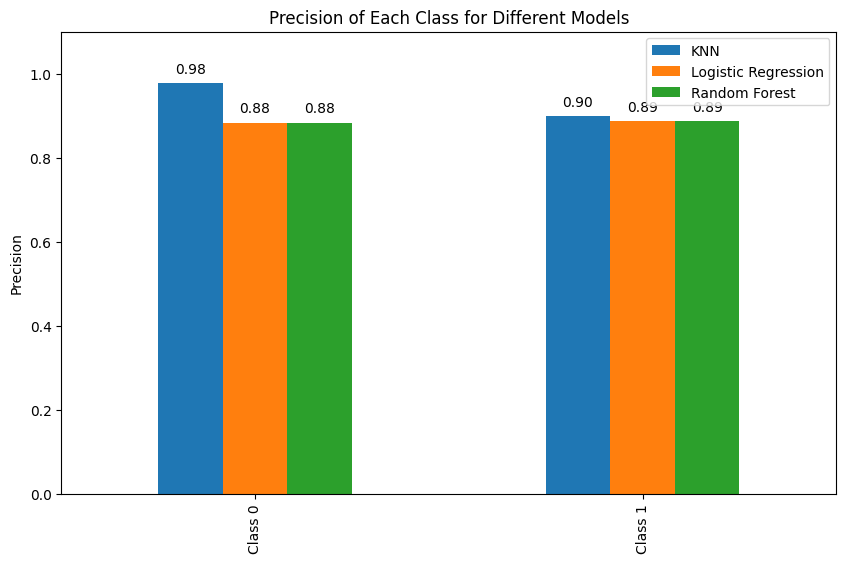

In [ ]:
# Vẽ biểu đồ
df_precisions = pd.DataFrame(precisions, index=['Class 0', 'Class 1'])
ax = df_precisions.plot(kind='bar', figsize=(10, 6))

# Thêm giá trị trên từng cột
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Precision of Each Class for Different Models')
plt.ylabel('Precision')
plt.ylim(0, 1.1)
plt.show()

# THỬ VỚI TỈ LỆ TRAIN TEST 7:3

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (smote)
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_resampled = df[['age', 'blood_glucose_level', 'HbA1c_level', 'bmi', 'hypertension','heart_disease']]
y_resampled = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [ ]:
X_train

,age,blood_glucose_level,HbA1c_level,bmi,hypertension,heart_disease
7803,17,130,4.0,19.53,0,0
29506,70,140,8.8,32.19,0,1
52935,43,126,6.5,30.40,0,0
58341,34,145,4.8,29.35,0,0
11327,77,200,4.5,24.05,0,1
...,...,...,...,...,...,...
6265,9,90,6.0,27.32,0,0
54886,53,126,6.5,22.46,0,0
76820,11,159,4.8,16.32,0,0
860,49,300,6.5,27.32,0,0


In [ ]:
# Nếu sài smote thì không chạy đoạn này
X = df[['age', 'blood_glucose_level', 'HbA1c_level', 'bmi', 'hypertension','heart_disease']]
y = df['diabetes']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## KNN

In [ ]:
# Xây dựng mô hình KNN với k=3
model_KNN = KNeighborsClassifier(n_neighbors=5)

# Huấn luyện mô hình trên tập huấn luyện
model_KNN.fit(X_train, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = model_KNN.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# In các độ đo đánh giá và ma trận nhầm lẫn
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)
print("Confusion matrix:")
print(confusion_mat)

Accuracy: 0.9474606668297058
Recall: 0.9930231614813613
Precision: 0.9105143749767546
F1-score: 0.9499805975941017
Confusion matrix:
[[22009  2406]
 [  172 24481]]


In [ ]:
# Xây dựng mô hình KNN mới
model_KNN_new = KNeighborsClassifier()

# Thiết lập các giá trị tham số để tìm kiếm
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}  # Các giá trị k để thử

# Tìm kiếm lưới để tìm giá trị tối ưu cho tham số k
grid_search = GridSearchCV(model_KNN_new, param_grid, cv=5)  # cv là số lượng fold trong cross-validation
grid_search.fit(X_train, y_train)

# Lấy kết quả tốt nhất từ tìm kiếm lưới
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print("Best k:", best_k)
print("Best score:", best_score)

Best k: 3
Best score: 0.9533679141682416


In [ ]:
# Xây dựng mô hình KNN với k=7
knn_model = KNeighborsClassifier(n_neighbors=best_k)

# Huấn luyện mô hình trên tập huấn luyện
knn_model.fit(X_train, y_train)

# Dự đoán nhãn cho tập kiểm tra
knn_y_pred = knn_model.predict(X_test)

# Đánh giá mô hình KNN
knn_accuracy = accuracy_score(y_test, knn_y_pred)
# Tính MSE
mse_knn = mean_squared_error(y_test, knn_y_pred)
# Tính MAE
mae_knn = mean_absolute_error(y_test, knn_y_pred)

# In độ chính xác của mô hình KNN
print("KNN accuracy:", knn_accuracy)
print(f"MSE của KNN: {mse_knn}")
print(f"MAE của KNN: {mae_knn}")

# Xuất ra báo cáo phân loại
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
# Lưu kết quả dự đoán từ class
precision_knn_0 = report['0']['precision']
precision_knn_1 = report['1']['precision']

KNN accuracy: 0.9620526616124562
MSE của KNN: 0.037947338387543814
MAE của KNN: 0.037947338387543814
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     24415
           1       0.91      0.99      0.95     24653

    accuracy                           0.95     49068
   macro avg       0.95      0.95      0.95     49068
weighted avg       0.95      0.95      0.95     49068



In [ ]:
# Lưu mô hình vào file
# filename = 'knn_model_Undersampling.pkl'
# filename = 'knn_model_Oversampling.pkl'
filename = 'knn_model_SMOTE.pkl'
joblib.dump(knn_model, filename)

## LOGISTIC REGRESSION

In [ ]:
# Xây dựng mô hình Logistic Regression
model_LR = LogisticRegression()

# Huấn luyện mô hình trên tập huấn luyện
model_LR.fit(X_train, y_train)

# Dự đoán nhãn cho tập kiểm tra
y_pred = model_LR.predict(X_test)

# Tính các độ đo đánh giá
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# In các độ đo đánh giá và ma trận nhầm lẫn
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)
print("Confusion matrix:")
print(confusion_mat)

Accuracy: 0.8801223241590214
Recall: 0.8765732846122615
Precision: 0.8837494883340156
F1-score: 0.8801467590705259
Confusion matrix:
[[2158  284]
 [ 304 2159]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Xây dựng mô hình Logistic Regression mới
model_LR_new = LogisticRegression()

# Thiết lập các giá trị tham số để thử nghiệm
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

# Tạo đối tượng GridSearchCV cho Logistic Regression
grid_search = GridSearchCV(estimator=model_LR_new, param_grid=param_grid, cv=5)

# Huấn luyện mô hình Logistic Regression trên tập huấn luyện với Grid Search
grid_search.fit(X_train, y_train)

# In ra các thông số tối ưu
print("Best parameters:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the lin

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
# Xây dựng mô hình Logistic Regression với các thông số tối ưu
logreg_model = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')

# Huấn luyện mô hình trên tập huấn luyện
logreg_model.fit(X_train, y_train)

# Đánh giá mô hình
accuracy = logreg_model.score(X_test, y_test)
mse_lr = mean_squared_error(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)


print("LR Accuracy:", accuracy)
print(f"MSE của LR: {mse_lr}")
print(f"MAE của LR: {mae_lr}")
# Xuất ra báo cáo phân loại
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
# Lưu kết quả dự đoán từ class
precision_logreg_0 = report['0']['precision']
precision_logreg_1 = report['1']['precision']

LR Accuracy: 0.8789842667318822
MSE của LR: 0.12091383386321024
MAE của LR: 0.12091383386321024
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     24415
           1       0.89      0.87      0.88     24653

    accuracy                           0.88     49068
   macro avg       0.88      0.88      0.88     49068
weighted avg       0.88      0.88      0.88     49068



In [ ]:
# Lưu mô hình vào file
# filename = 'logreg_model_Undersampling.pkl'
# filename = 'logreg_model_Oversampling.pkl'
filename = 'logreg_model_SMOTE_73.pkl'
joblib.dump(logreg_model, filename)

['logreg_model_SMOTE_73.pkl']

## RANDOM FOREST

In [ ]:
# Xây dựng mô hình Random Forest
model_RF = RandomForestClassifier()

# Huấn luyện mô hình trên tập huấn luyện
model_RF.fit(X_train, y_train)
# Dự đoán nhãn cho tập kiểm tra
y_pred = model_RF.predict(X_test)

# Tính các độ đo đánh giá
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# In các độ đo đánh giá và ma trận nhầm lẫn
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)
print("Confusion matrix:")
print(confusion_mat)

Accuracy: 0.9869772560528246
Recall: 0.9992109256449165
Precision: 0.9755259259259259
F1-score: 0.9872263868065967
Confusion matrix:
[[15824   413]
 [   13 16462]]


In [ ]:
# Xây dựng mô hình Random Forest
model_RF_new = RandomForestClassifier()

# Thiết lập các thông số để tìm kiếm tối ưu
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
}

# Tìm kiếm tối ưu thông qua Grid Search
grid_search = GridSearchCV(model_RF_new, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# In ra thông số tốt nhất
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
# Xây dựng mô hình Random Forest với các thông số tối ưu
random_forest_model = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2)

# Huấn luyện mô hình trên tập huấn luyện
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
# Đánh giá mô hình
accuracy = random_forest_model.score(X_test, y_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("RF Accuracy:", accuracy)
print(f"MSE của RF: {mse_rf}")
print(f"MAE của RF: {mae_rf}")
# Xuất ra báo cáo phân loại
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
# Lưu kết quả dự đoán từ class
precision_rf_0 = report['0']['precision']
precision_rf_1 = report['1']['precision']

RF Accuracy: 0.9872523844460749
MSE của RF: 0.012747615553925165
MAE của RF: 0.012747615553925165
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     16237
           1       0.98      1.00      0.99     16475

    accuracy                           0.99     32712
   macro avg       0.99      0.99      0.99     32712
weighted avg       0.99      0.99      0.99     32712



In [ ]:
# Lưu mô hình vào file
# filename = 'random_forest_model_Undersampling.pkl'
# filename = 'random_forest_model_Oversampling.pkl'
filename = 'random_forest_model_SMOTE_73.pkl'
joblib.dump(random_forest_model, filename)

['random_forest_model_SMOTE_73.pkl']

In [ ]:
# Lưu kết quả từ thuật toán
precisions = {
    'KNN': [precision_knn_0, precision_knn_1],
    'Logistic Regression': [precision_logreg_0, precision_logreg_1],
    'Random Forest': [precision_rf_0, precision_rf_1]
}
print(precisions)

{'KNN': [0.991439127692169, 0.9102850338617251], 'Logistic Regression': [0.875207582324112, 0.8848599204233152], 'Random Forest': [0.875207582324112, 0.8848599204233152]}


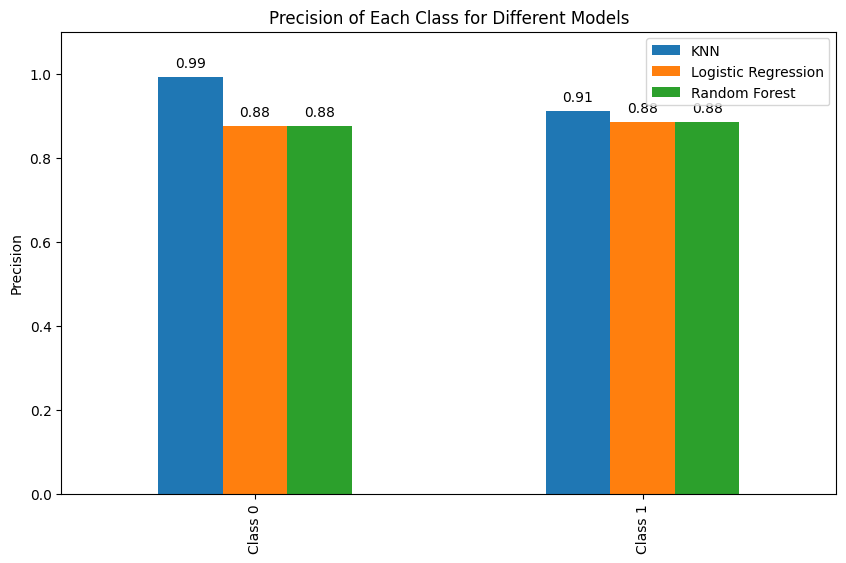

In [ ]:
# Vẽ biểu đồ
df_precisions = pd.DataFrame(precisions, index=['Class 0', 'Class 1'])
ax = df_precisions.plot(kind='bar', figsize=(10, 6))

# Thêm giá trị trên từng cột
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Precision of Each Class for Different Models')
plt.ylabel('Precision')
plt.ylim(0, 1.1)
plt.show()

# TIỀN XỬ LÍ DỮ LIỆU TƯƠNG ĐỒNG

In [ ]:
# Đọc dữ liệu vào DataFrame
df = pd.read_csv("sampled_data.csv")


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.shape

(1000, 9)

In [ ]:
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,53,0,0,0,25.62,5.7,200,0
1,0,79,0,1,4,16.33,5.7,126,0
2,0,28,0,0,1,24.16,3.5,155,0
3,1,66,0,0,5,26.63,5.7,145,0
4,1,36,0,0,5,38.54,6.2,130,0


In [ ]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [ ]:
# Xóa các hàng có giá trị NaN
df = df.dropna()

In [ ]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [ ]:
# Kiểm tra giá trị của các thuộc tính
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        print(f"Column: {col}")
        min_val = df[col].min()
        max_val = df[col].max()
        print(f"Minimum value: {min_val}")
        print(f"Maximum value: {max_val}")
    else:
        print(f"Column: {col}")
        unique_values = df[col].unique()
        print("Values: ",unique_values)

Column: gender
Minimum value: 0
Maximum value: 1
Column: age
Minimum value: 5
Maximum value: 80
Column: hypertension
Minimum value: 0
Maximum value: 1
Column: heart_disease
Minimum value: 0
Maximum value: 1
Column: smoking_history
Minimum value: 0
Maximum value: 5
Column: bmi
Minimum value: 14.18
Maximum value: 81.73
Column: HbA1c_level
Minimum value: 3.5
Maximum value: 9.0
Column: blood_glucose_level
Minimum value: 80
Maximum value: 300
Column: diabetes
Minimum value: 0
Maximum value: 1


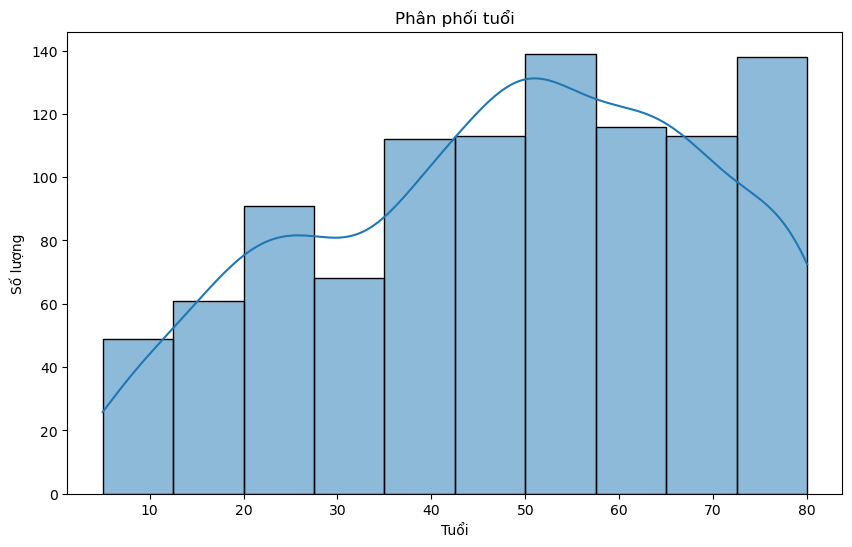

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=10, kde=True)
plt.title('Phân phối tuổi')
plt.xlabel('Tuổi')
plt.ylabel('Số lượng')
plt.show()

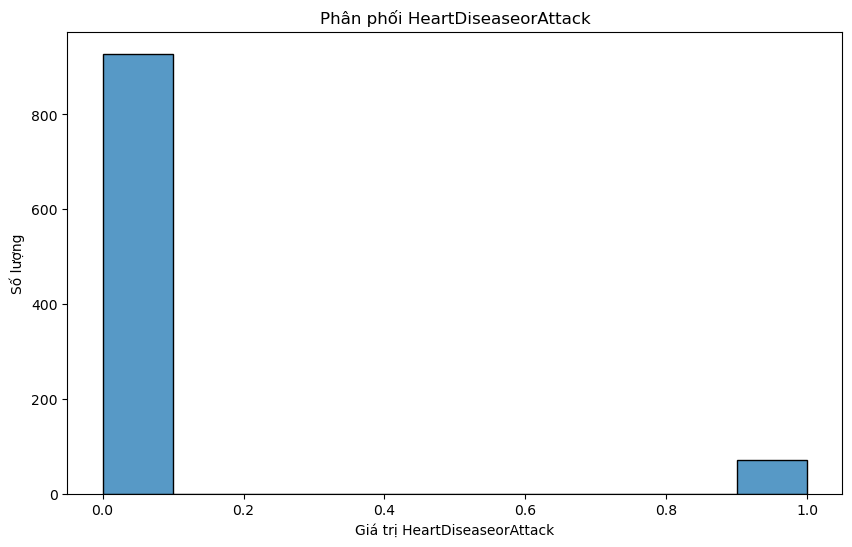

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['heart_disease'], bins=10)
plt.title('Phân phối HeartDiseaseorAttack')
plt.xlabel('Giá trị HeartDiseaseorAttack')
plt.ylabel('Số lượng')
plt.show()

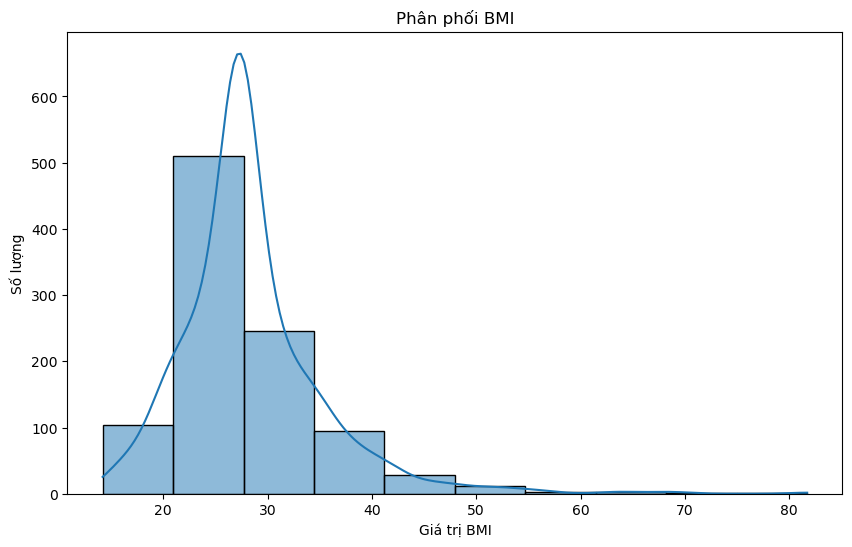

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['bmi'], bins=10, kde=True)
plt.title('Phân phối BMI')
plt.xlabel('Giá trị BMI')
plt.ylabel('Số lượng')
plt.show()

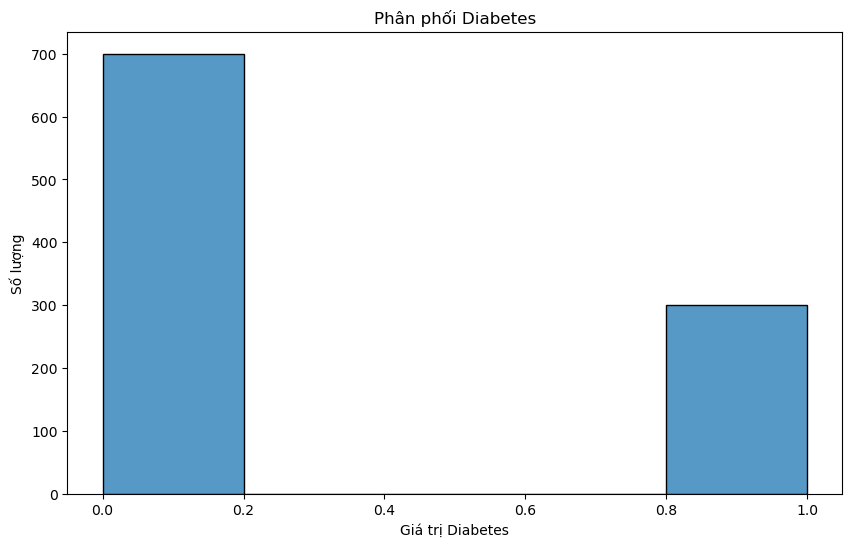

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['diabetes'], bins=5)
plt.title('Phân phối Diabetes')
plt.xlabel('Giá trị Diabetes')
plt.ylabel('Số lượng')
plt.show()

In [ ]:
# Lưu lại file đã tiền xử lý dữ liệu
df.to_csv('file_300.csv', index=False)

# TẠO VÀ LOẠI BỎ CÁC CỘT CẦN THIẾT

In [ ]:
# Đọc hai tập dữ liệu
diabetes_new = pd.read_csv('diabetes_new.csv')
diabetes = pd.read_csv('file_300.csv')



In [ ]:
diabetes.shape

(1000, 9)

In [ ]:
# In ra định dạng của các cột
print(diabetes.dtypes)

gender                   int64
age                      int64
hypertension             int64
heart_disease            int64
smoking_history          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [ ]:
print("\nSố lượng giá trị NaN trong mỗi cột:")
print(diabetes.isnull().sum())

# Xóa các hàng có giá trị NaN
diabetes = diabetes.dropna()

# Kiểm tra các giá trị NaN sau khi xóa
print("\nSố lượng giá trị NaN sau khi xóa các hàng có giá trị NaN:")
print(diabetes.isnull().sum())


Số lượng giá trị NaN trong mỗi cột:
diabetes         0
hypertension     0
bmi              0
Smoker           0
heart_disease    0
Sex              0
age              0
dtype: int64

Số lượng giá trị NaN sau khi xóa các hàng có giá trị NaN:
diabetes         0
hypertension     0
bmi              0
Smoker           0
heart_disease    0
Sex              0
age              0
dtype: int64


In [ ]:
diabetes['diabetes'] = diabetes['diabetes'].astype('int64')
diabetes['heart_disease'] = diabetes['heart_disease'].astype('int64')
diabetes['age'] = diabetes['age'].astype('int64')

In [ ]:
# Lưu tập dữ liệu mới vào file
diabetes.to_csv('data_with_new_attributes_mean.csv', index=False)

# THỰC NGHIỆM

## CHẠY THỰC NGHIỆM VỚI 200 DÒNG DỮ LIỆU GÓC

### KNN

In [ ]:
# Tải dữ liệu gốc và lấy mẫu ngẫu nhiên 100 dòng
data = pd.read_csv('diabetes_new.csv')

In [ ]:
# Xóa 2 cột gender và smoking_history
data.drop("gender", axis=1, inplace=True)
data.drop("smoking_history", axis=1, inplace=True)

In [ ]:
data

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80,0,1,25.19,6.6,140,0
1,54,0,0,27.32,6.6,80,0
2,28,0,0,27.32,5.7,158,0
3,36,0,0,23.45,5.0,155,0
4,76,1,1,20.14,4.8,155,0
...,...,...,...,...,...,...,...
89950,40,0,0,40.69,3.5,155,0
89951,36,0,0,24.60,4.8,145,0
89952,66,0,0,27.83,5.7,155,0
89953,24,0,0,35.42,4.0,100,0


In [ ]:
# Tải mô hình KNN đã huấn luyện
knn_model = joblib.load('knn_model_over.pkl')
# Tải mô hình LG đã huấn luyện
lg_model = joblib.load('/content/logreg_model_SMOTE_73.pkl')
# Tải mô hình RF đã huấn luyện
rf_model = joblib.load('/content/random_forest_model_SMOTE_73.pkl')

In [ ]:
# Hàm chạy dự đoán nhiều lần và lưu kết quả
def run_predictions(model, data, n_samples=100, runs=5):
    predictions = []
    for i in range(runs):
        # Lấy 100 dòng ngẫu nhiên mỗi lần chạy mà không cố định
        sample_data = data.sample(n=n_samples)
        X_sample = sample_data.drop('diabetes', axis=1)
        y_sample = sample_data['diabetes']

        X_sample = X_sample[model.feature_names_in_]

        y_pred = model.predict(X_sample)
        predictions.append((y_pred, y_sample))
    return predictions

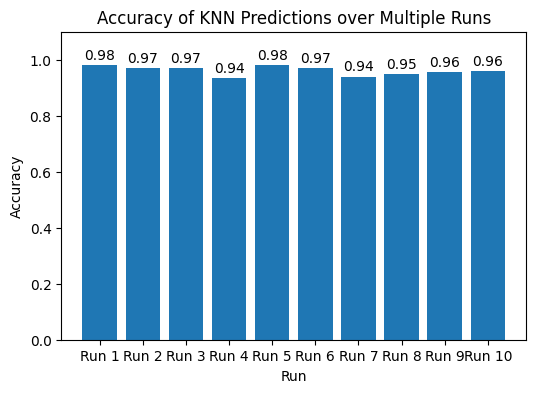

In [ ]:
# Chạy dự đoán 5 lần
predictions = run_predictions(knn_model, data, n_samples=200, runs=10)

# So sánh các lần dự đoán
comparison_list = []
for i, (y_pred, y_true) in enumerate(predictions):
    comparison = pd.DataFrame({
        f'Run {i+1}': y_pred,
        'True': y_true.values
    })
    comparison_list.append(comparison)


# Tính toán tỷ lệ dự đoán đúng cho từng lần chạy
accuracies_knn = []
temp = []
for comparison in comparison_list:
    accuracy = (comparison.drop('True', axis=1).values == comparison['True'].values.reshape(-1, 1)).mean(axis=0)
    accuracies_knn.append(accuracy)

# Vẽ biểu đồ tỷ lệ dự đoán đúng
plt.figure(figsize=(6, 4))
bars = plt.bar([f'Run {i+1}' for i in range(len(accuracies_knn))], [acc[0] for acc in accuracies_knn])
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN Predictions over Multiple Runs')

plt.ylim(0, 1.1)

# Hiển thị các giá trị chính xác trên các cột của bar plot
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()


In [ ]:
temp.append(accuracies_knn)

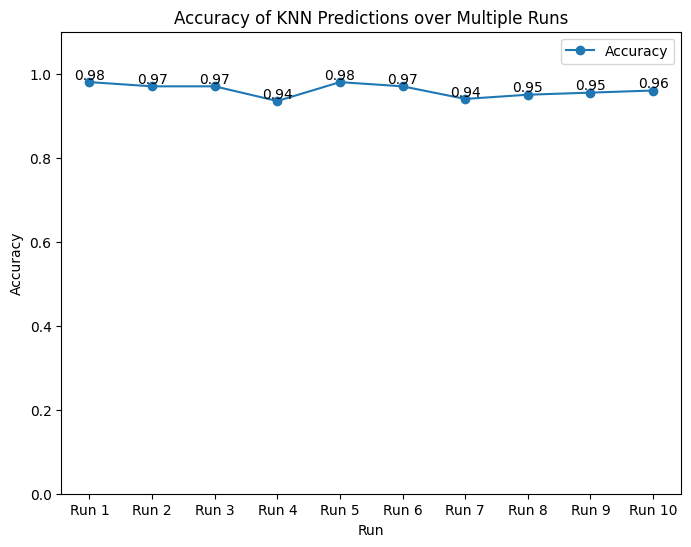

In [ ]:
# Vẽ biểu đồ tỷ lệ dự đoán đúng dưới dạng biểu đồ đường với chấm điểm
plt.figure(figsize=(8, 6))

# Tạo danh sách các lần chạy
runs = [f'Run {i+1}' for i in range(len(accuracies_knn))]

# Vẽ đường
plt.plot(runs, [acc[0] for acc in accuracies_knn], marker='o', linestyle='-', label='Accuracy')

# Hiển thị giá trị của từng chấm trên biểu đồ
for i, acc in enumerate(accuracies_knn):
    plt.text(runs[i], acc[0], f'{acc[0]:.2f}', ha='center', va='bottom')

plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN Predictions over Multiple Runs')
plt.legend()
plt.ylim(0, 1.1)  # Đảm bảo y-axis từ 0 đến 1

plt.show()

### LOGISTIC REGRESSION

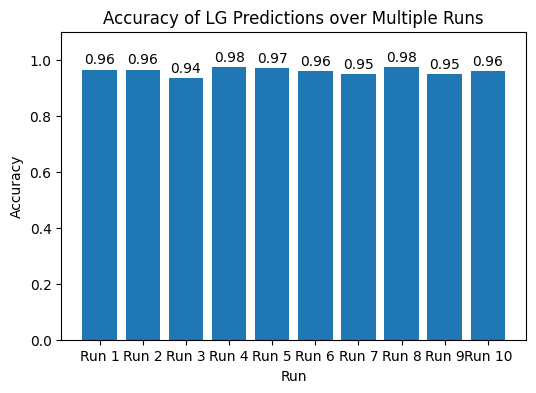

In [ ]:
# Chạy dự đoán 5 lần
predictions = run_predictions(lg_model, data, n_samples=200, runs=10)

# So sánh các lần dự đoán
comparison_list = []
for i, (y_pred, y_true) in enumerate(predictions):
    comparison = pd.DataFrame({
        f'Run {i+1}': y_pred,
        'True': y_true.values
    })
    comparison_list.append(comparison)


# Tính toán tỷ lệ dự đoán đúng cho từng lần chạy
accuracies_lg = []
temp = []
for comparison in comparison_list:
    accuracy = (comparison.drop('True', axis=1).values == comparison['True'].values.reshape(-1, 1)).mean(axis=0)
    accuracies_lg.append(accuracy)

# Vẽ biểu đồ tỷ lệ dự đoán đúng
plt.figure(figsize=(6, 4))
bars = plt.bar([f'Run {i+1}' for i in range(len(accuracies_lg))], [acc[0] for acc in accuracies_lg])
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of LG Predictions over Multiple Runs')

plt.ylim(0, 1.1)

# Hiển thị các giá trị chính xác trên các cột của bar plot
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

In [ ]:
temp.append(accuracies_lg)

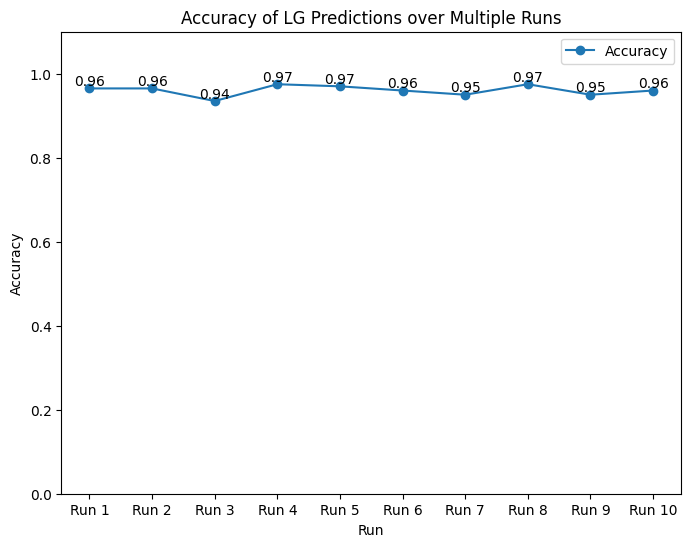

In [ ]:
# Vẽ biểu đồ tỷ lệ dự đoán đúng dưới dạng biểu đồ đường với chấm điểm
plt.figure(figsize=(8, 6))

# Tạo danh sách các lần chạy
runs = [f'Run {i+1}' for i in range(len(accuracies_lg))]

# Vẽ đường
plt.plot(runs, [acc[0] for acc in accuracies_lg], marker='o', linestyle='-', label='Accuracy')

# Hiển thị giá trị của từng chấm trên biểu đồ
for i, acc in enumerate(accuracies_lg):
    plt.text(runs[i], acc[0], f'{acc[0]:.2f}', ha='center', va='bottom')

plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of LG Predictions over Multiple Runs')
plt.legend()
plt.ylim(0, 1.1)  # Đảm bảo y-axis từ 0 đến 1

plt.show()

### RANDOM FOREST

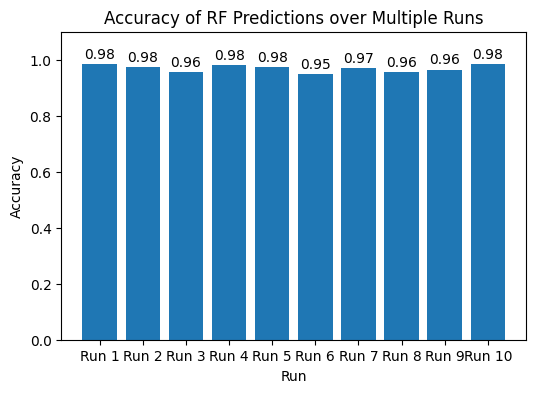

In [ ]:
# Chạy dự đoán 5 lần
predictions = run_predictions(rf_model, data, n_samples=200, runs=10)

# So sánh các lần dự đoán
comparison_list = []
for i, (y_pred, y_true) in enumerate(predictions):
    comparison = pd.DataFrame({
        f'Run {i+1}': y_pred,
        'True': y_true.values
    })
    comparison_list.append(comparison)


# Tính toán tỷ lệ dự đoán đúng cho từng lần chạy
accuracies_rf = []
temp = []
for comparison in comparison_list:
    accuracy = (comparison.drop('True', axis=1).values == comparison['True'].values.reshape(-1, 1)).mean(axis=0)
    accuracies_rf.append(accuracy)

# Vẽ biểu đồ tỷ lệ dự đoán đúng
plt.figure(figsize=(6, 4))
bars = plt.bar([f'Run {i+1}' for i in range(len(accuracies_rf))], [acc[0] for acc in accuracies_rf])
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of RF Predictions over Multiple Runs')

plt.ylim(0, 1.1)

# Hiển thị các giá trị chính xác trên các cột của bar plot
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

In [ ]:
temp.append(accuracies_rf)

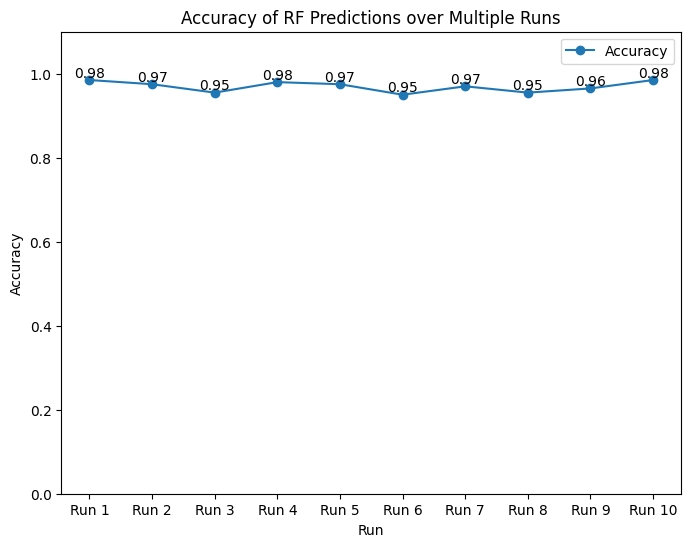

In [ ]:
# Vẽ biểu đồ tỷ lệ dự đoán đúng dưới dạng biểu đồ đường với chấm điểm
plt.figure(figsize=(8, 6))

# Tạo danh sách các lần chạy
runs = [f'Run {i+1}' for i in range(len(accuracies_rf))]

# Vẽ đường
plt.plot(runs, [acc[0] for acc in accuracies_rf], marker='o', linestyle='-', label='Accuracy')

# Hiển thị giá trị của từng chấm trên biểu đồ
for i, acc in enumerate(accuracies_rf):
    plt.text(runs[i], acc[0], f'{acc[0]:.2f}', ha='center', va='bottom')

plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of RF Predictions over Multiple Runs')
plt.legend()
plt.ylim(0, 1.1)  # Đảm bảo y-axis từ 0 đến 1

plt.show()

## CHẠY THỰC NGHIỆM TRÊN DỮ LIỆU THỰC NGHIỆM

In [ ]:
data_td = pd.read_csv('/content/sampled_data.csv')

In [ ]:
data_td

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,53,0,0,0,25.62,5.7,200,0
1,0,79,0,1,4,16.33,5.7,126,0
2,0,28,0,0,1,24.16,3.5,155,0
3,1,66,0,0,5,26.63,5.7,145,0
4,1,36,0,0,5,38.54,6.2,130,0
...,...,...,...,...,...,...,...,...,...
995,0,48,0,0,0,53.97,9.0,280,1
996,0,55,1,0,4,37.41,7.0,159,1
997,0,75,0,1,5,26.22,7.0,200,1
998,0,80,1,1,3,27.32,6.0,220,1


In [ ]:
data_td.shape

(1000, 9)

In [ ]:
# Xóa 2 cột gender và smoking_history
data_td.drop("gender", axis=1, inplace=True)
data_td.drop("smoking_history", axis=1, inplace=True)

### KNN

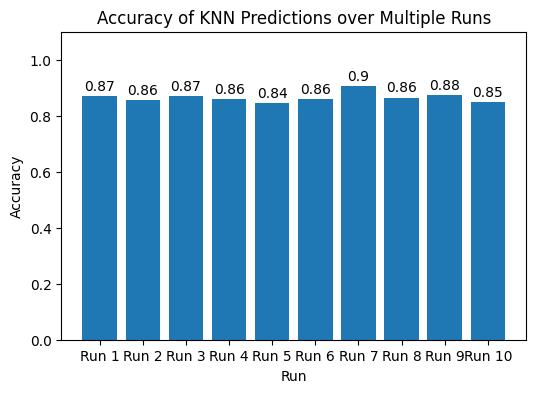

In [ ]:
# Chạy dự đoán 3 lần
predictions = run_predictions(knn_model, data_td, n_samples=200, runs=10)

# So sánh các lần dự đoán
comparison_list = []
for i, (y_pred, y_true) in enumerate(predictions):
    comparison = pd.DataFrame({
        f'Run {i+1}': y_pred,
        'True': y_true.values
    })
    comparison_list.append(comparison)


# Tính toán tỷ lệ dự đoán đúng cho từng lần chạy
accuracies_knn_td = []
for comparison in comparison_list:
    accuracy_td = (comparison.drop('True', axis=1).values == comparison['True'].values.reshape(-1, 1)).mean(axis=0)
    accuracies_knn_td.append(accuracy_td)

# Vẽ biểu đồ tỷ lệ dự đoán đúng
plt.figure(figsize=(6, 4))
bars = plt.bar([f'Run {i+1}' for i in range(len(accuracies_knn_td))], [acc[0] for acc in accuracies_knn_td])
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN Predictions over Multiple Runs')

plt.ylim(0, 1.1)

# Hiển thị các giá trị chính xác trên các cột của bar plot
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()


In [ ]:
temp.append(accuracies_knn_td)

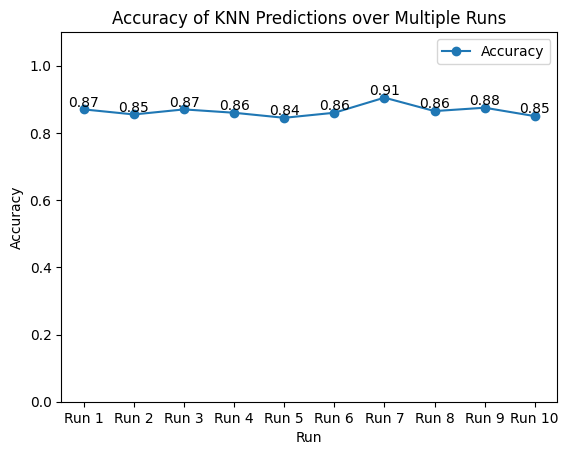

In [ ]:
# Vẽ đường
plt.plot(runs, [acc[0] for acc in accuracies_knn_td], marker='o', linestyle='-', label='Accuracy')

# Hiển thị giá trị của từng chấm trên biểu đồ
for i, acc in enumerate(accuracies_knn_td):
    plt.text(runs[i], acc[0], f'{acc[0]:.2f}', ha='center', va='bottom')

plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN Predictions over Multiple Runs')
plt.legend()
plt.ylim(0, 1.1)  # Đảm bảo y-axis từ 0 đến 1
plt.show()

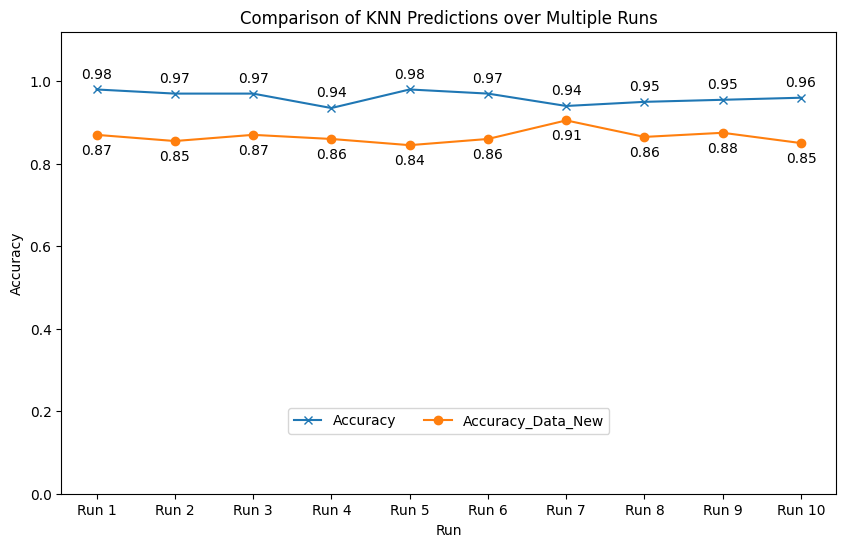

In [ ]:
plt.figure(figsize=(10, 6))

# Vẽ đường cho accuracies
plt.plot(runs, [acc[0] for acc in accuracies_knn], marker='x', linestyle='-', label='Accuracy')

# Vẽ đường cho accuracies_td
plt.plot(runs, [acc[0] for acc in accuracies_knn_td], marker='o', linestyle='-', label='Accuracy_Data_New')

# Hiển thị giá trị của từng chấm trên biểu đồ cho cả hai đường
for i, (acc_knn, acc_knn_td) in enumerate(zip(accuracies_knn, accuracies_knn_td)):
    if acc_knn[0] < acc_knn_td[0]:
        plt.text(runs[i], acc_knn[0] - 0.02, f'{acc_knn[0]:.2f}', ha='center', va='top')
        plt.text(runs[i], acc_knn_td[0] + 0.02, f'{acc_knn_td[0]:.2f}', ha='center', va='bottom')
    else:
        plt.text(runs[i], acc_knn[0] + 0.02, f'{acc_knn[0]:.2f}', ha='center', va='bottom')
        plt.text(runs[i], acc_knn_td[0] - 0.02, f'{acc_knn_td[0]:.2f}', ha='center', va='top')

plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Comparison of KNN Predictions over Multiple Runs')
# Di chuyển legend xuống dưới biểu đồ
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.2), ncol=2)
plt.ylim(0, 1.12)  # Đảm bảo y-axis từ 0 đến 1
plt.show()

### LOGISTIC REGRESSION

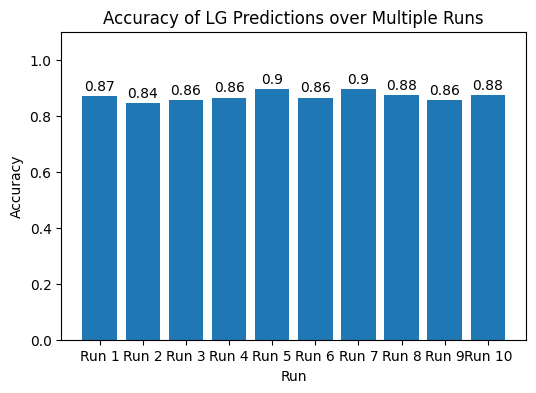

In [ ]:
# Chạy dự đoán 3 lần
predictions = run_predictions(lg_model, data_td, n_samples=200, runs=10)

# So sánh các lần dự đoán
comparison_list = []
for i, (y_pred, y_true) in enumerate(predictions):
    comparison = pd.DataFrame({
        f'Run {i+1}': y_pred,
        'True': y_true.values
    })
    comparison_list.append(comparison)


# Tính toán tỷ lệ dự đoán đúng cho từng lần chạy
accuracies_lg_td = []
for comparison in comparison_list:
    accuracy_td = (comparison.drop('True', axis=1).values == comparison['True'].values.reshape(-1, 1)).mean(axis=0)
    accuracies_lg_td.append(accuracy_td)

# Vẽ biểu đồ tỷ lệ dự đoán đúng
plt.figure(figsize=(6, 4))
bars = plt.bar([f'Run {i+1}' for i in range(len(accuracies_lg_td))], [acc[0] for acc in accuracies_lg_td])
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of LG Predictions over Multiple Runs')

plt.ylim(0, 1.1)

# Hiển thị các giá trị chính xác trên các cột của bar plot
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

In [ ]:
temp.append(accuracies_lg_td)

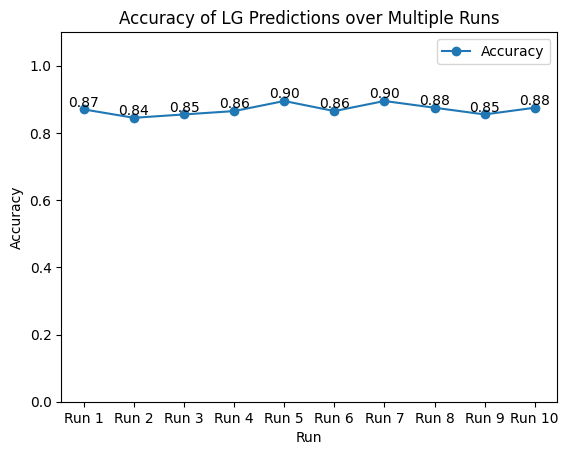

In [ ]:

# Vẽ đường
plt.plot(runs, [acc[0] for acc in accuracies_lg_td], marker='o', linestyle='-', label='Accuracy')

# Hiển thị giá trị của từng chấm trên biểu đồ
for i, acc in enumerate(accuracies_lg_td):
    plt.text(runs[i], acc[0], f'{acc[0]:.2f}', ha='center', va='bottom')

plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of LG Predictions over Multiple Runs')
plt.legend()
plt.ylim(0, 1.1)  # Đảm bảo y-axis từ 0 đến 1
plt.show()

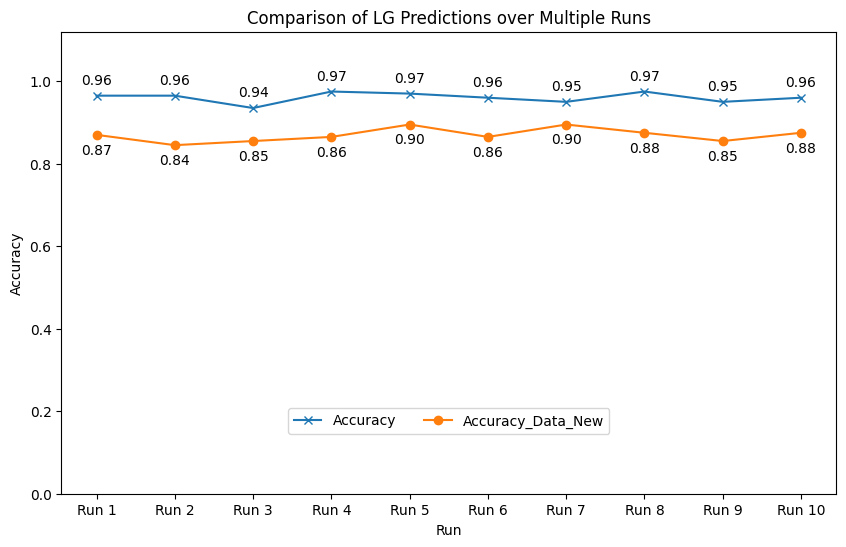

In [ ]:
plt.figure(figsize=(10, 6))

# Vẽ đường cho accuracies
plt.plot(runs, [acc[0] for acc in accuracies_lg], marker='x', linestyle='-', label='Accuracy')

# Vẽ đường cho accuracies_td
plt.plot(runs, [acc[0] for acc in accuracies_lg_td], marker='o', linestyle='-', label='Accuracy_Data_New')

# Hiển thị giá trị của từng chấm trên biểu đồ cho cả hai đường
for i, (acc_lg, acc_lg_td) in enumerate(zip(accuracies_lg, accuracies_lg_td)):
    if acc_lg[0] < acc_lg_td[0]:
        plt.text(runs[i], acc_lg[0] - 0.02, f'{acc_lg[0]:.2f}', ha='center', va='top')
        plt.text(runs[i], acc_lg_td[0] + 0.02, f'{acc_lg_td[0]:.2f}', ha='center', va='bottom')
    else:
        plt.text(runs[i], acc_lg[0] + 0.02, f'{acc_lg[0]:.2f}', ha='center', va='bottom')
        plt.text(runs[i], acc_lg_td[0] - 0.02, f'{acc_lg_td[0]:.2f}', ha='center', va='top')

plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Comparison of LG Predictions over Multiple Runs')
# Di chuyển legend xuống dưới biểu đồ
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.2), ncol=2)
plt.ylim(0, 1.12)  # Đảm bảo y-axis từ 0 đến 1
plt.show()

### RANDOM FOREST

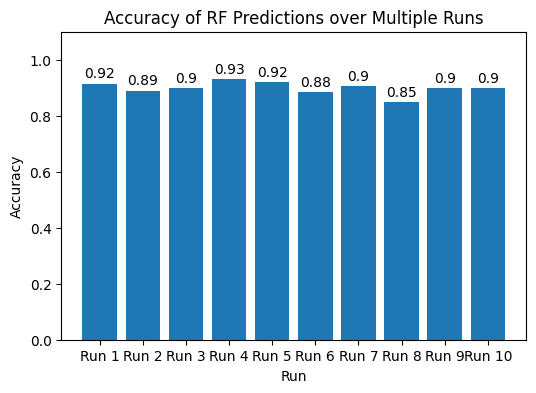

In [ ]:
# Chạy dự đoán 3 lần
predictions = run_predictions(rf_model, data_td, n_samples=200, runs=10)

# So sánh các lần dự đoán
comparison_list = []
for i, (y_pred, y_true) in enumerate(predictions):
    comparison = pd.DataFrame({
        f'Run {i+1}': y_pred,
        'True': y_true.values
    })
    comparison_list.append(comparison)


# Tính toán tỷ lệ dự đoán đúng cho từng lần chạy
accuracies_rf_td = []
for comparison in comparison_list:
    accuracy_td = (comparison.drop('True', axis=1).values == comparison['True'].values.reshape(-1, 1)).mean(axis=0)
    accuracies_rf_td.append(accuracy_td)

# Vẽ biểu đồ tỷ lệ dự đoán đúng
plt.figure(figsize=(6, 4))
bars = plt.bar([f'Run {i+1}' for i in range(len(accuracies_rf_td))], [acc[0] for acc in accuracies_rf_td])
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of RF Predictions over Multiple Runs')

plt.ylim(0, 1.1)

# Hiển thị các giá trị chính xác trên các cột của bar plot
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

In [ ]:
temp.append(accuracies_rf_td)

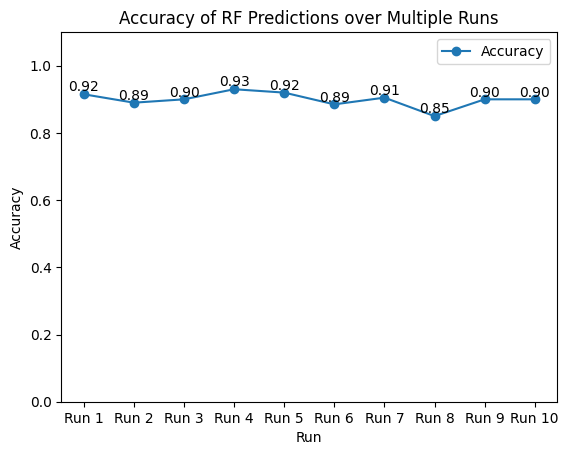

In [ ]:
# Vẽ đường
plt.plot(runs, [acc[0] for acc in accuracies_rf_td], marker='o', linestyle='-', label='Accuracy')

# Hiển thị giá trị của từng chấm trên biểu đồ
for i, acc in enumerate(accuracies_rf_td):
    plt.text(runs[i], acc[0], f'{acc[0]:.2f}', ha='center', va='bottom')

plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of RF Predictions over Multiple Runs')
plt.legend()
plt.ylim(0, 1.1)  # Đảm bảo y-axis từ 0 đến 1
plt.show()

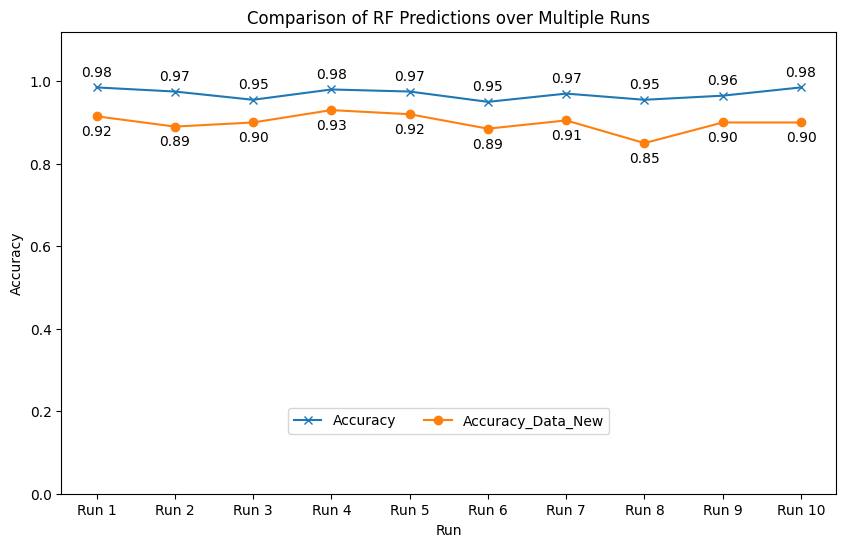

In [ ]:
plt.figure(figsize=(10, 6))

# Vẽ đường cho accuracies
plt.plot(runs, [acc[0] for acc in accuracies_rf], marker='x', linestyle='-', label='Accuracy')

# Vẽ đường cho accuracies_td
plt.plot(runs, [acc[0] for acc in accuracies_rf_td], marker='o', linestyle='-', label='Accuracy_Data_New')

# Hiển thị giá trị của từng chấm trên biểu đồ cho cả hai đường
for i, (acc_rf, acc_rf_td) in enumerate(zip(accuracies_rf, accuracies_rf_td)):
    if acc_rf[0] < acc_rf_td[0]:
        plt.text(runs[i], acc_rf[0] - 0.02, f'{acc_rf[0]:.2f}', ha='center', va='top')
        plt.text(runs[i], acc_rf_td[0] + 0.02, f'{acc_rf_td[0]:.2f}', ha='center', va='bottom')
    else:
        plt.text(runs[i], acc_rf[0] + 0.02, f'{acc_rf[0]:.2f}', ha='center', va='bottom')
        plt.text(runs[i], acc_rf_td[0] - 0.02, f'{acc_rf_td[0]:.2f}', ha='center', va='top')

plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Comparison of RF Predictions over Multiple Runs')
# Di chuyển legend xuống dưới biểu đồ
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.2), ncol=2)
plt.ylim(0, 1.12)  # Đảm bảo y-axis từ 0 đến 1
plt.show()